## Import lib

In [1]:
import os, random, math, copy, numpy as np, torch, pandas as pd
import json

import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display
from sklearn.model_selection import StratifiedKFold

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import random_split, DataLoader, Dataset, Subset
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder

import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## Data Loading

In [2]:
# Set the path to training and test folders
DATASET_PATH = '/kaggle/input/plantcity/PlantCity A Comprehensive Image Based on Multi Cro/PlantCity A Comprehensive Image Based on Multi Cro/Images'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train', 'train')
TEST_PATH = os.path.join(DATASET_PATH, 'test', 'test')

In [3]:
def build_metadata(data_path, split='train'):
    metadata = []
    for class_folder in sorted(os.listdir(data_path)):
        class_path = os.path.join(data_path, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)
                    try:
                        with Image.open(img_path) as img:
                            width, height = img.size
                    except:
                        width, height = (0, 0)  # Corrupt image
                    metadata.append({
                        'split': split,
                        'class': class_folder,
                        'filename': img_file,
                        'width': width,
                        'height': height
                    })
    return pd.DataFrame(metadata)

In [4]:
df_train = build_metadata(TRAIN_PATH, 'train')
df_test = build_metadata(TEST_PATH, 'test')

In [5]:
df = pd.concat([df_train, df_test], ignore_index=True)
print(f"Total images: {len(df)}")
df.head()

Total images: 52273


,split,class,filename,width,height
0,train,Apple Brown_spot,623.jpg,1000,800
1,train,Apple Brown_spot,764.jpg,1000,800
2,train,Apple Brown_spot,771.jpg,1000,800
3,train,Apple Brown_spot,208.jpg,1000,800
4,train,Apple Brown_spot,820.jpg,1000,800


## Thesis Plots/Graphs

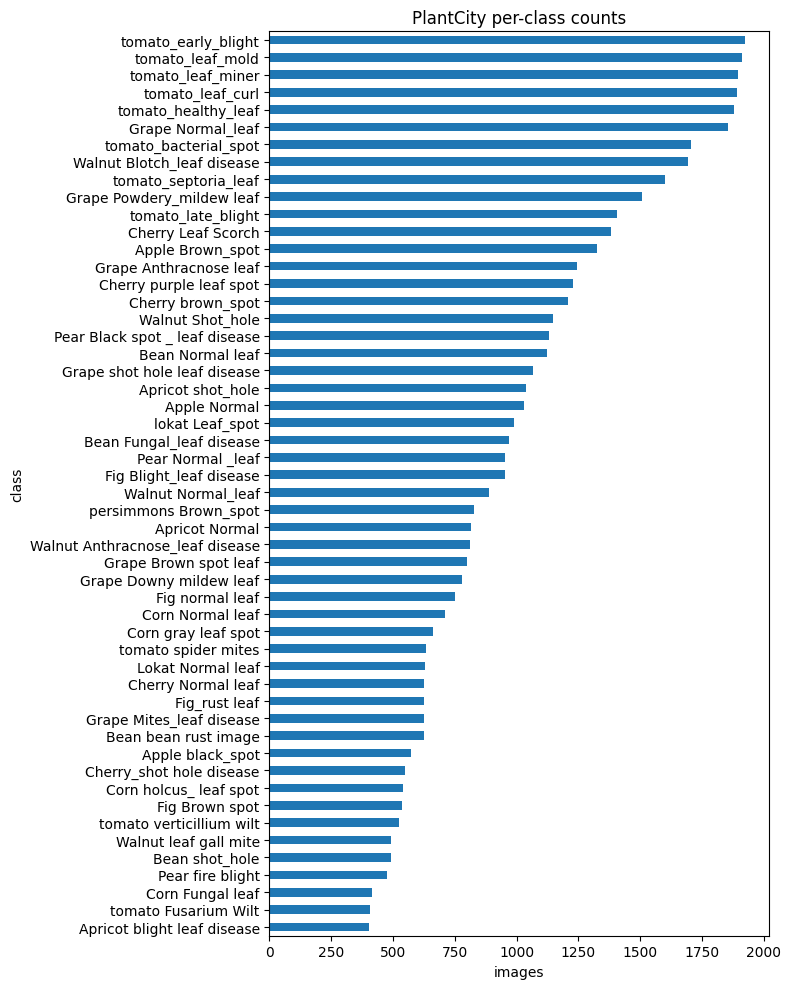

In [6]:
# 1) Per-class counts (sorted)
c = df.groupby('class').size().sort_values()
plt.figure(figsize=(8,10)); c.plot(kind='barh'); plt.xlabel('images'); plt.ylabel('class'); 
plt.title('PlantCity per-class counts'); plt.tight_layout(); plt.show()

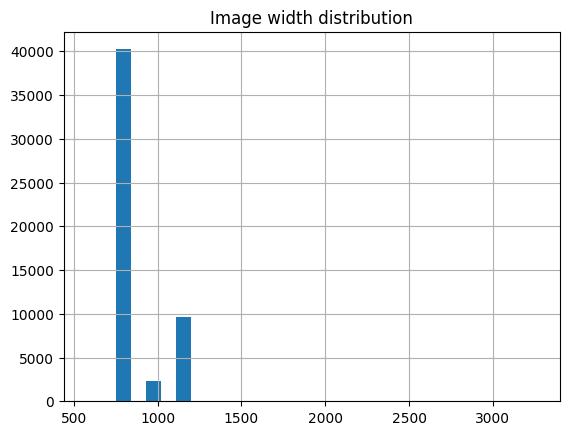

In [7]:
# 2) Resolution histogram
from PIL import Image
def get_size(fp): 
    with Image.open(fp) as im: return im.size
if 'width' not in df.columns:
    sizes = df['filepath'].apply(get_size)
    df['width']  = sizes.apply(lambda s: s[0])
    df['height'] = sizes.apply(lambda s: s[1])
plt.figure(); df['width'].hist(bins=30); plt.title('Image width distribution'); plt.show()

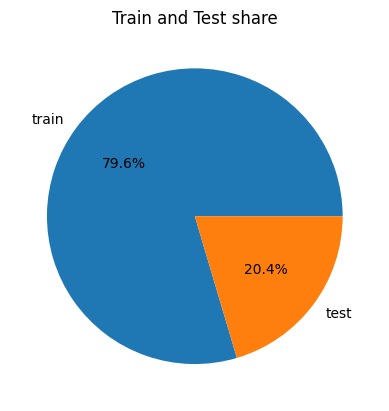

In [8]:
# 3) Split composition
plt.figure(); df['split'].value_counts().plot(kind='pie', autopct='%1.1f%%'); 
plt.ylabel(''); plt.title('Train and Test share'); plt.show()

In [9]:
df.columns

Index(['split', 'class', 'filename', 'width', 'height'], dtype='object')

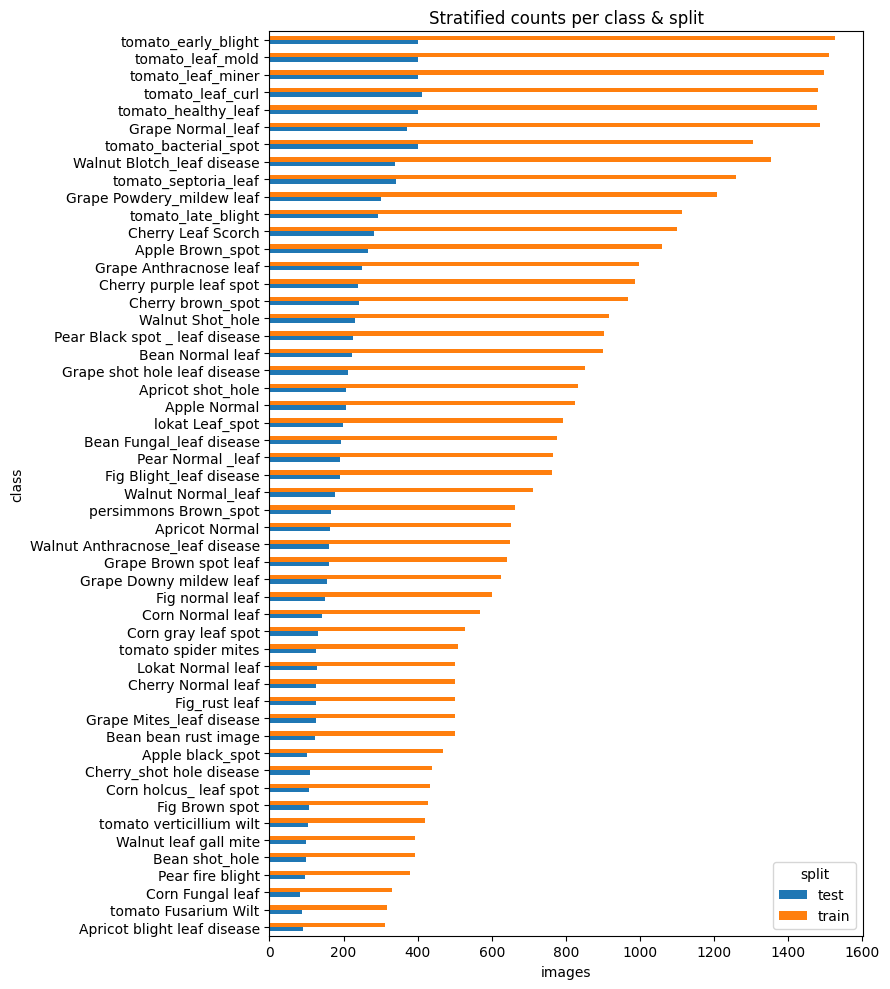

In [10]:
pivot = pd.pivot_table(df,index='class', columns='split', aggfunc='size', fill_value=0)
pivot = pivot.loc[pivot.sum(axis=1).sort_values().index]
ax = pivot.plot(kind='barh', stacked=False, figsize=(9, 10))
ax.legend(title='split')
ax.set_xlabel('images')
ax.set_title('Stratified counts per class & split')
plt.tight_layout()
plt.show()

## EDA

In [11]:
df['split_path'] = df['split'] + "/" + df['split']

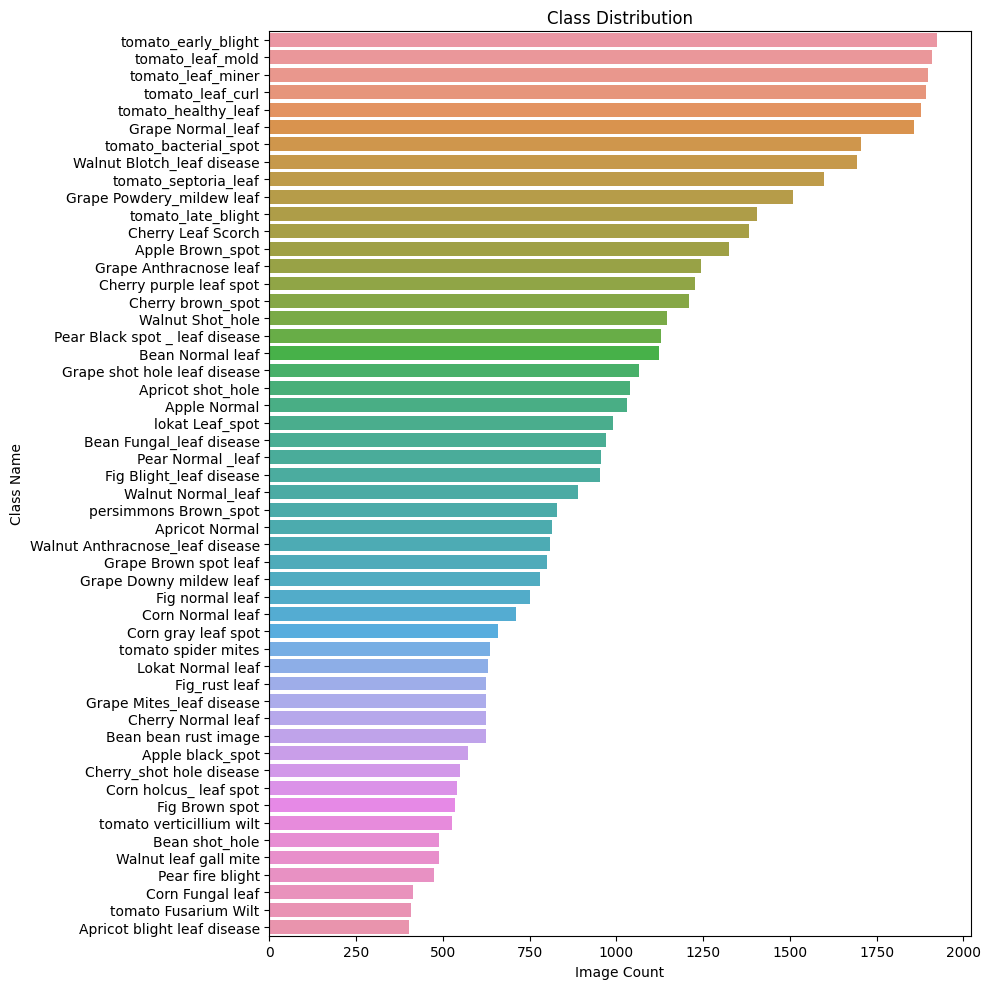

In [12]:
topN = 52
counts = df['class'].value_counts()
top_classes = counts.head(topN).index            # or: counts.nlargest(topN).index

# optional: keep only those rows (safer)
df_top = df[df['class'].isin(top_classes)]

plt.figure(figsize=(10, 10))
sns.countplot(data=df_top, y='class', order=top_classes[::1])  #[::-1] puts biggest at top
plt.title(f"Class Distribution") #  (Top {topN})
plt.xlabel("Image Count")
plt.ylabel("Class Name")
plt.tight_layout()
plt.show()

Class Distribution (Train + Test)

🔍 Interpretation:
Highly imbalanced: Some classes like tomato_early_blight, tomato_leaf_mold, etc., have nearly 2000 images, while classes like Apricot blight leaf disease, Corn holcus_ leaf spot, and Cherry shot hole disease have fewer than 300.

You have 52 distinct classes — a clear multi-class classification problem.

🧠 Implication:
We’ll need to:

Use class weights during training.

Possibly downsample dominant classes or augment rare ones.

Evaluate performance using macro-averaged metrics like F1-score, not just accuracy.

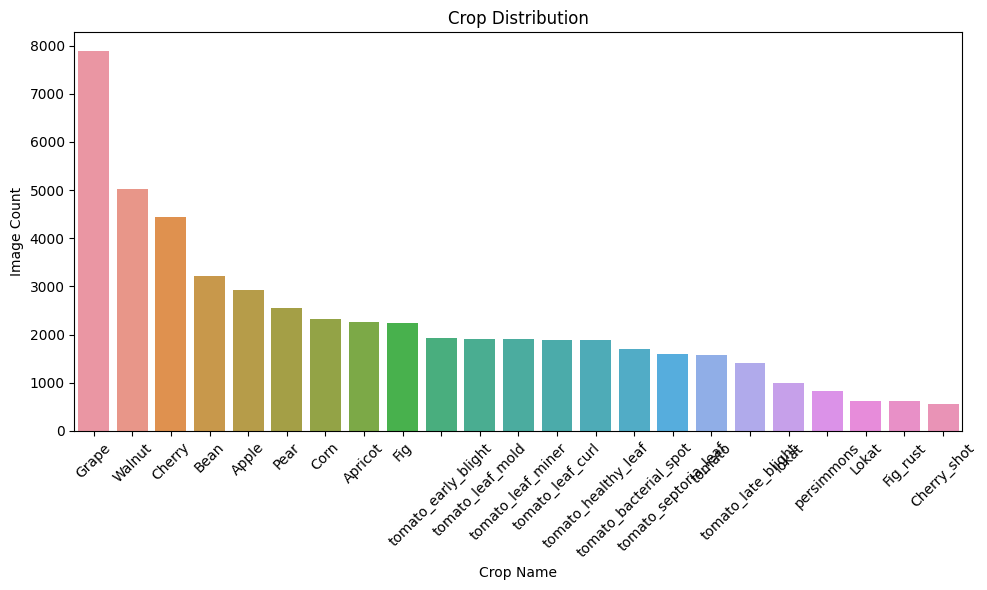

In [13]:
# Crop distribution
df['crop'] = df['class'].apply(lambda x: x.split()[0])  # First word is usually the crop name

# Crop-wise distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='crop', order=df['crop'].value_counts().index)
plt.title("Crop Distribution")
plt.ylabel("Image Count")
plt.xlabel("Crop Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

✅ 2. Crop Distribution

🔍 Interpretation:
Grape, Walnut, and Cherry dominate the dataset.

Crops like Loquat, Persimmons, Fig have relatively few samples.

🧠 Implication:
Some crops are well-represented (good for per-crop classification).

Some crops have only 1–2 disease classes → great candidates for binary classification or specialized sub-models.

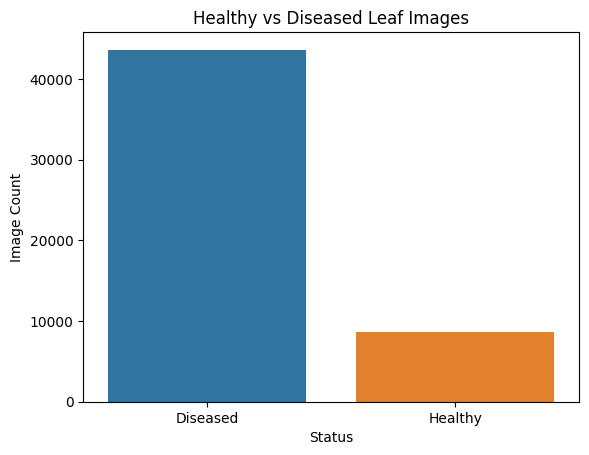

In [14]:
# Healthy vs Diseased
df['health_status'] = df['class'].apply(lambda x: 'Healthy' if 'Normal' in x else 'Diseased')

sns.countplot(data=df, x='health_status')
plt.title("Healthy vs Diseased Leaf Images")
plt.xlabel("Status")
plt.ylabel("Image Count")
plt.show()

✅ 3. Healthy vs Diseased

🔍 Interpretation:
Diseased images (~44,000+) far outnumber healthy ones (~8,000).

You have 11 healthy classes and 41 disease classes.

🧠 Implication:
This imbalance needs to be considered if training a binary classifier (Healthy vs Diseased).

Again, weighted loss will be necessary.

Healthy images still cover a variety of crops — avoid overfitting to just one "healthy look".


Class: Walnut leaf gall mite (490 images)


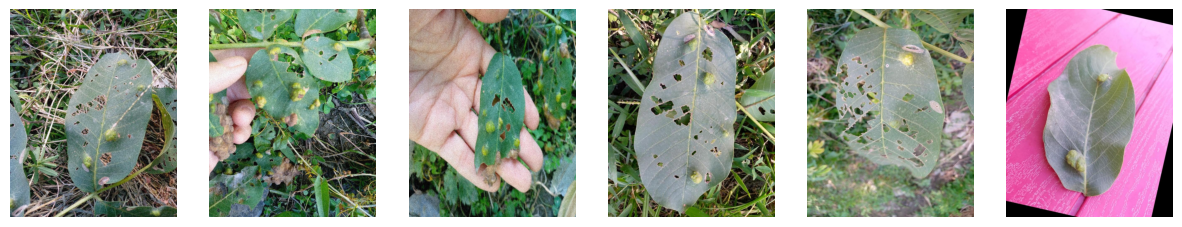


Class: Grape Normal_leaf (1857 images)


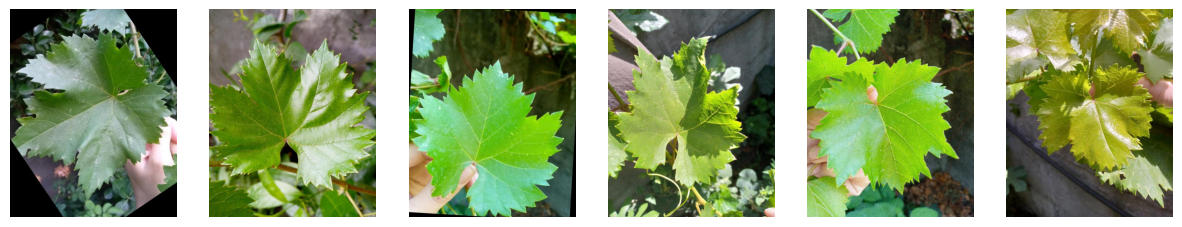


Class: Cherry brown_spot (1210 images)


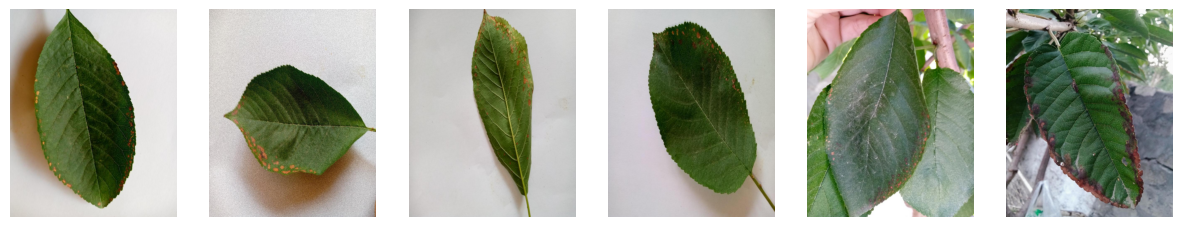

In [15]:
def show_class_samples(df, selected_classes, n=6):
    for class_name in selected_classes:
        subset = df[df['class'] == class_name]
        sample_paths = subset.sample(min(n, len(subset))).reset_index()
        print(f"\nClass: {class_name} ({len(subset)} images)")
        fig, axs = plt.subplots(1, n, figsize=(15, 3))
        for i, row in sample_paths.iterrows():
            img = Image.open(os.path.join(DATASET_PATH, row['split_path'], row['class'], row['filename']))
            axs[i].imshow(img)
            axs[i].axis('off')
        plt.show()

# Show 3 example classes
random_classes = random.sample(list(df['class'].unique()), 3)
show_class_samples(df, random_classes)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


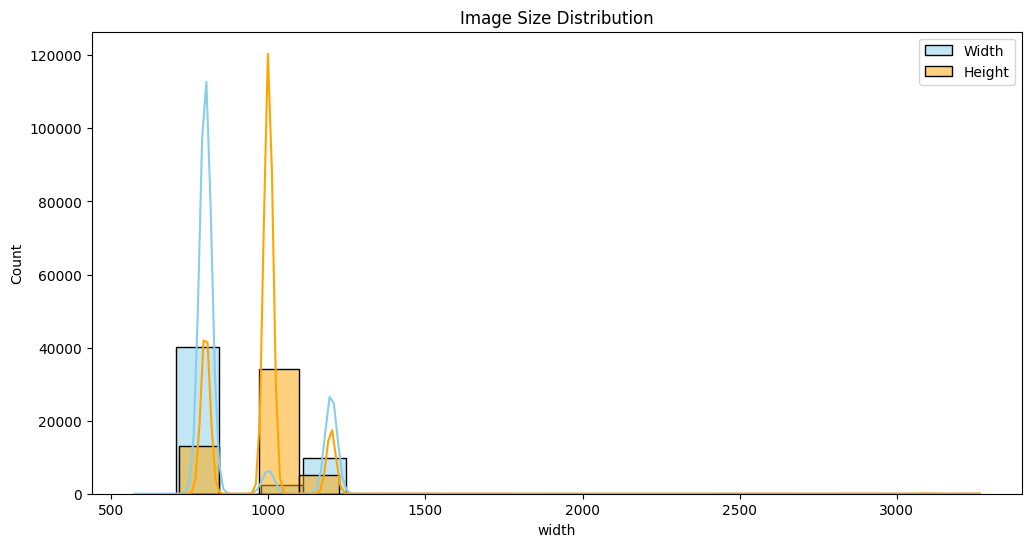

Unique image sizes: [[1000  800]
 [ 800 1000]
 [ 800  800]
 [1500 1000]
 [1200  800]
 [ 800 1200]
 [3088 3088]
 [3264 2448]
 [2448 3264]
 [1280 1280]
 [ 711  858]
 [ 800  882]
 [ 738  916]
 [ 716  972]
 [ 800  923]
 [ 702  900]
 [ 800  717]
 [ 713  947]
 [ 771  902]
 [ 761  953]
 [ 781  956]
 [ 765  845]
 [ 780  843]
 [ 800  862]
 [ 651  860]
 [ 573  860]
 [ 692  797]
 [ 782  801]]


In [16]:
# Check image dimension consistency
plt.figure(figsize=(12, 6))
sns.histplot(df['width'], bins=20, color='skyblue', label='Width', kde=True)
sns.histplot(df['height'], bins=20, color='orange', label='Height', kde=True)
plt.title("Image Size Distribution")
plt.legend()
plt.show()

print(f"Unique image sizes: {df[['width', 'height']].drop_duplicates().values}")

✅ 5. Image Sizes

🔍 Interpretation:
Most images cluster around:

1000×800, 800×800, and 1200×800

Some outliers up to 3888×3888

🧠 Implication:
Resize all images to a fixed size before feeding into models:

For AlexNet/GoogleNet: 224×224

For ViT: 224×224 or 384×384

Outliers might slow training — best to resize all during dataset loading.

In [17]:
# Base dataset path
BASE_PATH = "/kaggle/input/plantcity/PlantCity A Comprehensive Image Based on Multi Cro/PlantCity A Comprehensive Image Based on Multi Cro/Images"
TRAIN_DIR = os.path.join(BASE_PATH, "train", "train")
TEST_DIR = os.path.join(BASE_PATH, "test", "test")

# Check a few class folders
print("Sample training classes:", os.listdir(TRAIN_DIR)[:5])
print("Sample test classes:", os.listdir(TEST_DIR)[:5])

Sample training classes: ['Grape shot hole leaf disease', 'Cherry_shot hole disease', 'tomato Fusarium Wilt', 'Grape Mites_leaf disease', 'Fig normal leaf']
Sample test classes: ['Grape shot hole leaf disease', 'Cherry_shot hole disease', 'tomato Fusarium Wilt', 'Grape Mites_leaf disease', 'Fig normal leaf']


In [18]:
# Use ImageFolder to detect classes automatically
temp_dataset = datasets.ImageFolder(TRAIN_DIR)
class_to_idx = temp_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Display class index mapping
print(f"Total classes: {len(class_to_idx)}\n")
for i, (k, v) in enumerate(class_to_idx.items()):
    print(f"{i:2d}: {k}")

Total classes: 52

 0: Apple Brown_spot
 1: Apple Normal
 2: Apple black_spot
 3: Apricot Normal
 4: Apricot blight leaf disease
 5: Apricot shot_hole
 6: Bean Fungal_leaf disease
 7: Bean Normal leaf
 8: Bean bean rust image
 9: Bean shot_hole
10: Cherry Leaf Scorch
11: Cherry Normal leaf
12: Cherry brown_spot
13: Cherry purple leaf spot
14: Cherry_shot hole disease
15: Corn Fungal leaf
16: Corn Normal leaf
17: Corn gray leaf spot
18: Corn holcus_ leaf spot
19: Fig Blight_leaf disease
20: Fig Brown spot
21: Fig normal leaf
22: Fig_rust leaf
23: Grape Anthracnose leaf
24: Grape Brown spot leaf
25: Grape Downy mildew leaf
26: Grape Mites_leaf disease
27: Grape Normal_leaf
28: Grape Powdery_mildew leaf
29: Grape shot hole leaf disease
30: Lokat Normal leaf
31: Pear Black spot _ leaf disease
32: Pear Normal _leaf
33: Pear fire blight
34: Walnut Anthracnose_leaf disease
35: Walnut Blotch_leaf disease
36: Walnut Normal_leaf
37: Walnut Shot_hole
38: Walnut leaf gall mite
39: lokat Leaf_spot


## Pre-processing

In [19]:
# Data Transforms (Resize, Normalize, Augment)
IMG_SIZE = 224  # Resize for AlexNet/GoogLeNet/VisionTransformer

# Mean and std from ImageNet
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

to_rgb = transforms.Lambda(lambda img: img.convert("RGB"))

# Transforms for training and test/val
train_transform = transforms.Compose([
    to_rgb,
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    to_rgb,
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [20]:
# Creating datasets
# Training dataset (we'll split into train + val)
full_train_dataset = ImageFolder(TRAIN_DIR, transform=train_transform)

# Test dataset (optional for now)
test_dataset = ImageFolder(TEST_DIR, transform=test_transform)

# Check sample
print(f"Total images in full train dataset: {len(full_train_dataset)}")
print(f"Total images in test dataset: {len(test_dataset)}")

Total images in full train dataset: 41606
Total images in test dataset: 10667


In [21]:
# Train/Val Split + DataLoaders
# 80-20 split
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Use different transforms for validation
val_dataset.dataset.transform = test_transform

# DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3,
                         pin_memory=True, persistent_workers=True,
                          prefetch_factor=2, timeout=60
                         )

val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3,
                         pin_memory=True, persistent_workers=True,
                          prefetch_factor=2, timeout=60
                         )

test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3,
                         pin_memory=True, persistent_workers=True,
                          prefetch_factor=2, timeout=60
                         )

# Confirm loader shapes
batch = next(iter(train_loader))
print(f"Sample batch shape: {batch[0].shape}, Labels: {batch[1][:5]}")

Sample batch shape: torch.Size([64, 3, 224, 224]), Labels: tensor([12,  5, 42, 42, 50])


In [22]:
from pathlib import Path
num_classes = len(class_to_idx)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ARTIFACTS_DIR = Path("./artifacts"); 
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

device

device(type='cuda')

In [23]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

In [24]:
@torch.no_grad()
def prf_metrics(model, loader, device, averages=("macro", "weighted", "micro")):
    """
    Computes overall Precision/Recall/F1 (+ Accuracy) on a loader.
    - averages: any of ("macro", "weighted", "micro")
      * macro   = unweighted mean over classes (treats classes equally)
      * weighted= class-frequency weighted mean
      * micro   = global TP/FP/FN (== accuracy for single-label multiclass)
    """
    model.eval()
    all_preds, all_labels = [], []

    for imgs, labels in tqdm(loader, leave=False, desc="Scoring"):
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    out = {"accuracy": accuracy_score(y_true, y_pred)}
    for avg in averages:
        out[f"precision_{avg}"] = precision_score(y_true, y_pred, average=avg, zero_division=0)
        out[f"recall_{avg}"]    = recall_score(y_true, y_pred, average=avg, zero_division=0)
        out[f"f1_{avg}"]        = f1_score(y_true, y_pred, average=avg, zero_division=0)
    return out

In [ ]:
# from pathlib import Path
# outdir = Path("/content/plantcity_curves")
# outdir.mkdir(parents=True, exist_ok=True)

In [ ]:
# for name, d in curves.items():
#     # normalize lengths by using the keys present
#     keys = sorted([k for k in d.keys() if k.endswith(("acc", "loss"))])
#     max_len = max(len(d[k]) for k in keys)
#     epochs = list(range(1, max_len+1))
#     df = pd.DataFrame({"epoch": epochs})
#     for k in ["train_acc","val_acc","train_loss","val_loss"]:
#         if k in d:
#             df[k] = pd.Series(d[k], dtype=float)
#     path = outdir / f"curves_{name.replace(' ','_').replace('/','-').lower()}.csv"
#     df.to_csv(path, index=False)

In [ ]:
# def plot_metric(metric_key, ylabel, ylim=None, smooth=1,
#                 columnwidth_pt=252, height_pt=200, legend_loc="best"):
#     """
#     Plot one metric with legend INSIDE the axes and figure sized to LaTeX column width.

#     Args:
#         metric_key:   key in curves[model]
#         ylabel:       y-axis label
#         ylim:         (ymin, ymax) or None
#         smooth:       moving-average window (>=1)
#         columnwidth_pt: LaTeX \columnwidth in points (default 252 pt)
#         height_pt:      figure height in points (default 200 pt)
#         legend_loc:     legend location INSIDE axes (e.g., 'best','lower right',...)
#     """
#     assert isinstance(curves, dict), "`curves` dict must exist"

#     import numpy as np
#     import matplotlib.pyplot as plt

#     def _ma(y, k):
#         if k <= 1: return np.asarray(y, dtype=float)
#         y = np.asarray(y, dtype=float)
#         pad_left, pad_right = k // 2, k - 1 - (k // 2)
#         ypad = np.pad(y, (pad_left, pad_right), mode="edge")
#         w = np.ones(k, dtype=float) / k
#         return np.convolve(ypad, w, mode="valid")

#     # collect series
#     series, max_len = [], 0
#     for name, d in curves.items():
#         if metric_key in d and len(d[metric_key]) > 0:
#             y = _ma(d[metric_key], smooth)
#             x = np.arange(1, len(y) + 1)
#             series.append((name, x, y))
#             max_len = max(max_len, len(y))
#     if not series:
#         raise ValueError(f"No data found for metric '{metric_key}'.")

#     # --- sizing: convert LaTeX points -> inches (72.27 pt per inch) ---
#     inch = 1.0 / 72.27
#     fig_w = columnwidth_pt * inch
#     fig_h = height_pt * inch

#     plt.rcParams.update({"font.size": 9})
#     fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=300)

#     for name, x, y in series:
#         ax.plot(x, y, linewidth=1.8, label=name)  # no explicit colors

#     ax.set_xlabel("Epoch")
#     ax.set_ylabel(ylabel)
#     ax.set_xlim(1, max_len)
#     if ylim is not None:
#         ax.set_ylim(*ylim)

#     ax.minorticks_on()
#     ax.grid(which="major", linewidth=0.6, alpha=0.55)
#     ax.grid(which="minor", linestyle=":", linewidth=0.4, alpha=0.35)

#     # legend INSIDE the plot
#     ax.legend(loc=legend_loc, frameon=False)   # e.g., 'best', 'lower right', 'upper left', ...

#     fig.tight_layout(pad=0.6)
#     return fig, ax

In [ ]:
# plot_metric("train_acc", "Training Accuracy", ylim=(0.75,1), smooth=1, legend="right")
# plot_metric("val_acc",   "Validation Accuracy", ylim=(0.4,1), smooth=1)
# plot_metric("train_loss","Training Loss", smooth=1, legend="right")
# plot_metric("val_loss",  "Validation Loss", smooth=1, legend="right")

In [ ]:
# # also create a compact summary table of final-epoch values
# rows = []
# for name, d in curves.items():
#     rows.append({
#         "model": name,
#         "epochs_train_acc": len(d.get("train_acc", [])),
#         "final_train_acc":  d.get("train_acc", [np.nan])[-1] if d.get("train_acc") else np.nan,
#         "final_val_acc":    d.get("val_acc", [np.nan])[-1] if d.get("val_acc") else np.nan,
#         "final_train_loss": d.get("train_loss", [np.nan])[-1] if d.get("train_loss") else np.nan,
#         "final_val_loss":   d.get("val_loss", [np.nan])[-1] if d.get("val_loss") else np.nan,
#     })
# summary_df = pd.DataFrame(rows)
# summary_csv = outdir / "final_epoch_summary.csv"
# summary_df.to_csv(summary_csv, index=False)

## Custom CNN with 3 layers

In [25]:
class SimpleCNNv1(nn.Module):
    """
    3 conv blocks -> GAP -> FC
    ~1–2M params, quick to train at 224x224.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.10),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.10),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.10),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # (B,C,1,1)
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [26]:
model_cnnv1 = SimpleCNNv1(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_cnnv1.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [27]:
EPOCHS = 10
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best, best_path = 0.0, ARTIFACTS_DIR / "cnn_3L_best.pth"

for ep in range(EPOCHS):
    tl, ta = train_one_epoch(model_cnnv1, train_loader, optimizer, criterion)
    vl, va = evaluate(model_cnnv1, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tl)
    history["train_acc"].append(ta)
    history["val_loss"].append(vl)
    history["val_acc"].append(va)

    print(f"[CNN-3L] Epoch {ep+1}/{EPOCHS} | train {ta:.2f}/{tl:.2f} | val {va:.2f}/{vl:.2f}")
    
    if va > best:
        best = va
        torch.save({
            "model": model_cnnv1.state_dict(),
            "class_to_idx": class_to_idx,
            "epoch": ep+1,
            "val_acc": best,
        }, best_path)
        print(f"  ↳ Saved new best to {best_path}")

# Epoch 1/10 | Train 0.37/2.59 | Val 0.48/2.01
# Epoch 2/10 | Train 0.56/1.75 | Val 0.60/1.48
# Epoch 3/10 | Train 0.64/1.35 | Val 0.66/1.20
# Epoch 4/10 | Train 0.71/1.08 | Val 0.70/1.05
# Epoch 5/10 | Train 0.76/0.90 | Val 0.77/0.84
# Epoch 6/10 | Train 0.80/0.76 | Val 0.79/0.74
# Epoch 7/10 | Train 0.83/0.67 | Val 0.82/0.64
# Epoch 8/10 | Train 0.84/0.59 | Val 0.84/0.59
# Epoch 9/10 | Train 0.86/0.53 | Val 0.84/0.52
# Epoch 10/10 | Train 0.88/0.49 | Val 0.88/0.48

Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 1/10 | train 0.38/2.55 | val 0.48/1.99
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 2/10 | train 0.56/1.72 | val 0.59/1.53
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 3/10 | train 0.66/1.31 | val 0.70/1.10
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 4/10 | train 0.72/1.05 | val 0.73/1.00
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 5/10 | train 0.77/0.88 | val 0.78/0.82
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 6/10 | train 0.80/0.75 | val 0.79/0.73
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 7/10 | train 0.83/0.65 | val 0.82/0.65
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 8/10 | train 0.85/0.58 | val 0.84/0.58
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 9/10 | train 0.87/0.51 | val 0.86/0.51
  ↳ Saved new best to artifacts/cnn_3L_best.pth


Training:   0%|          | 0/521 [00:00<?, ?it/s]

Validating:   0%|          | 0/131 [00:00<?, ?it/s]

[CNN-3L] Epoch 10/10 | train 0.88/0.47 | val 0.88/0.43
  ↳ Saved new best to artifacts/cnn_3L_best.pth


In [28]:
import os, json, random
# save history & plots
with open(ARTIFACTS_DIR / "cnn_3L_history.json", "w") as f:
    json.dump(history, f, indent=2)

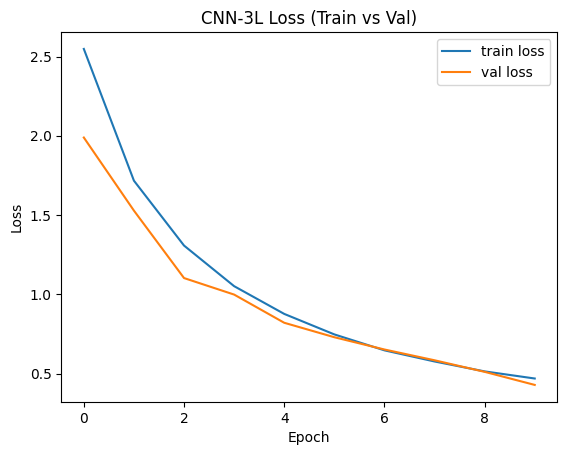

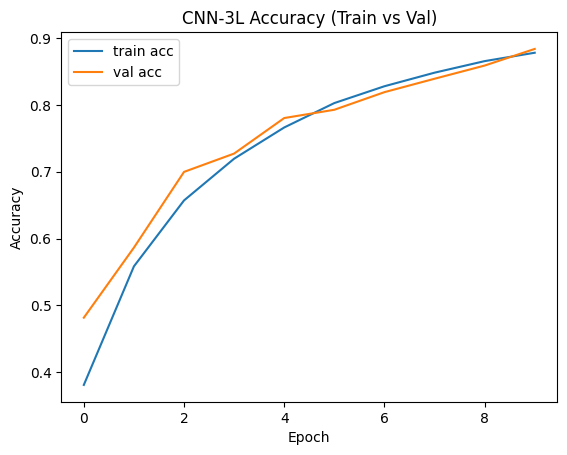

In [29]:
plt.figure(); 
plt.plot(history["train_loss"], label="train loss"); 
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); plt.title("CNN-3L Loss (Train vs Val)"); 
plt.legend(); 
plt.savefig(ARTIFACTS_DIR / "cnn_3L_loss_combined.png"); 
plt.show()
plt.close()

plt.figure(); 
plt.plot(history["train_acc"], label="train acc"); 
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.title("CNN-3L Accuracy (Train vs Val)"); 
plt.legend(); plt.savefig(ARTIFACTS_DIR / "cnn_3L_acc_combined.png"); 
plt.show()
plt.close()

In [30]:
# final test metrics
ckpt = torch.load(best_path, map_location=device)
model_cnnv1.load_state_dict(ckpt["model"])
test_loss, test_acc = evaluate(model_cnnv1, test_loader, criterion)
print(f"[CNN-3L] Test → loss {test_loss:.4f} | acc {test_acc:.4f}")

Validating:   0%|          | 0/167 [00:00<?, ?it/s]

[CNN-3L] Test → loss 0.3826 | acc 0.8941


In [31]:
metrics = prf_metrics(model_cnnv1, test_loader, device)
print("\n[CNN-3L] Test metrics:")
for k in ["accuracy","precision_macro","recall_macro","f1_macro","precision_weighted","recall_weighted","f1_weighted","precision_micro","recall_micro","f1_micro"]:
    if k in metrics:
        print(f" {k}: {metrics[k]:.4f}")
with open(ARTIFACTS_DIR / "cnn_3L_test_metrics.json", "w") as f:
    json.dump(metrics | {"test_loss": test_loss, "test_acc": test_acc}, f, indent=2)

Scoring:   0%|          | 0/167 [00:00<?, ?it/s]


[CNN-3L] Test metrics:
 accuracy: 0.8941
 precision_macro: 0.8993
 recall_macro: 0.8747
 f1_macro: 0.8829
 precision_weighted: 0.8998
 recall_weighted: 0.8941
 f1_weighted: 0.8934
 precision_micro: 0.8941
 recall_micro: 0.8941
 f1_micro: 0.8941


In [32]:
from tqdm import tqdm
import numpy as np

# Collect predictions and true labels
model_cnnv1.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Collecting predictions"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_cnnv1(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(f"Collected {len(y_true)} predictions for confusion matrix.")

Collected 10667 predictions for confusion matrix.


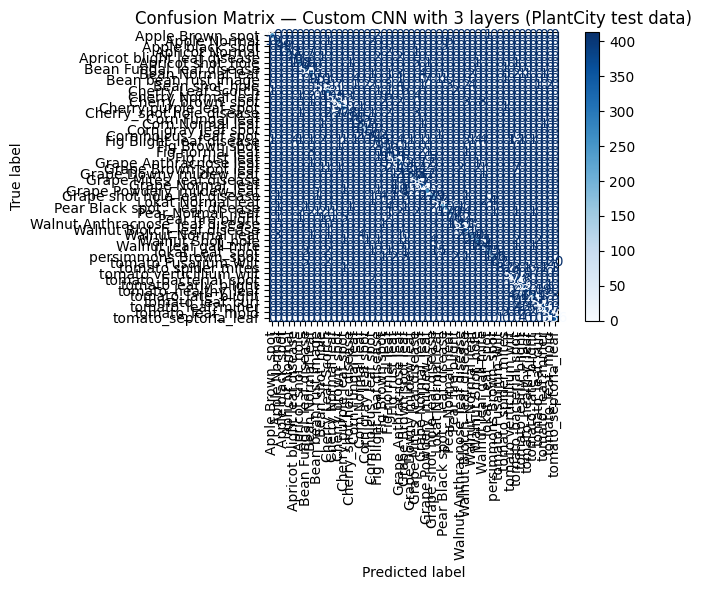

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize=None)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format="d")
plt.title("Confusion Matrix — Custom CNN with 3 layers (PlantCity test data)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

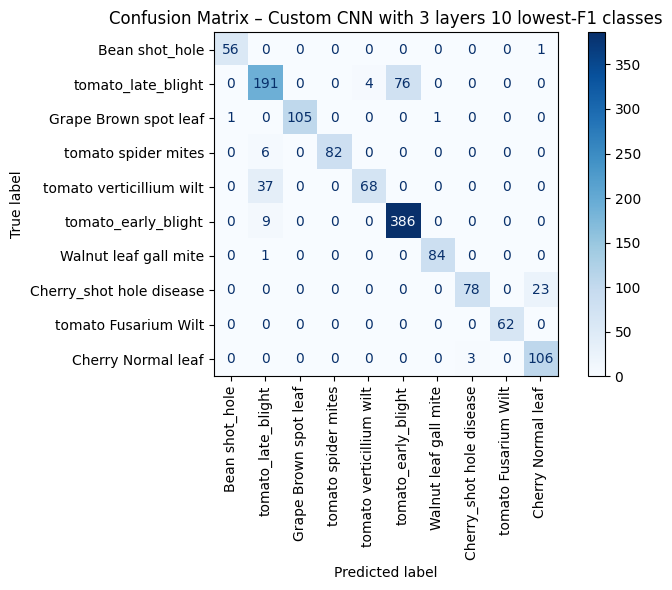

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

idx_to_class = {v: k for k, v in class_to_idx.items()}

# 1) Per-class F1 scores
f1_per_class = f1_score(y_true, y_pred, average=None)

# 2) Get indices of 10 worst classes (ascending F1)
worst_idx = np.argsort(f1_per_class)[:10]

# 3) Build confusion matrix and slice to worst 10
# cm_full = confusion_matrix(y_true, y_pred)
cm_worst = cm[np.ix_(worst_idx, worst_idx)]

worst_labels = [idx_to_class[i] for i in worst_idx]

# 4) Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_worst,
                              display_labels=worst_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Confusion Matrix – Custom CNN with 3 layers 10 lowest-F1 classes")
plt.tight_layout()
plt.show()

## Custom CNN with 4 layers

In [ ]:
class SimpleCNNv2(nn.Module):
    """
    Deeper: add an extra 256-channel block.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.10),

            # 2
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.10),

            # 3
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.10),

            # 4 (extra depth)
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.10),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

In [ ]:
model_cnnv2 = SimpleCNNv2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_cnnv2.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [ ]:
EPOCHS = 10
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best, best_path = 0.0, ARTIFACTS_DIR / "cnn_4L_best.pth"

for ep in range(EPOCHS):
    tl, ta = train_one_epoch(model_cnnv2, train_loader, optimizer, criterion)
    vl, va = evaluate(model_cnnv2, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tl)
    history["train_acc"].append(ta)
    history["val_loss"].append(vl)
    history["val_acc"].append(va)

    print(f"[CNN-4L] Epoch {ep+1}/{EPOCHS} | train {ta:.2f}/{tl:.2f} | val {va:.2f}/{vl:.2f}")
    
    if va > best:
        best = va
        torch.save({
            "model": model_cnnv2.state_dict(),
            "class_to_idx": class_to_idx,
            "epoch": ep+1,
            "val_acc": best,
        }, best_path)
        print(f"  ↳ Saved new best to {best_path}")

In [ ]:
# save history & plots
import json
with open(ARTIFACTS_DIR / "cnn_4L_history.json", "w") as f:
    json.dump(history, f, indent=2)

In [ ]:
plt.figure(); 
plt.plot(history["train_loss"], label="train loss"); 
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); plt.title("CNN-4L Loss (Train vs Val)"); 
plt.legend(); 
plt.savefig(ARTIFACTS_DIR / "cnn_4L_loss_combined.png"); 
plt.show()
plt.close()

plt.figure(); 
plt.plot(history["train_acc"], label="train acc"); 
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.title("CNN-4L Accuracy (Train vs Val)"); 
plt.legend(); plt.savefig(ARTIFACTS_DIR / "cnn_4L_acc_combined.png"); 
plt.show()
plt.close()

In [ ]:
# final test metrics
ckpt = torch.load(best_path, map_location=device)
model_cnnv2.load_state_dict(ckpt["model"])
test_loss, test_acc = evaluate(model_cnnv2, test_loader, criterion)
print(f"[CNN-4L] Test → loss {test_loss:.4f} | acc {test_acc:.4f}")

In [ ]:
metrics = prf_metrics(model_cnnv2, test_loader, device)
print("\n[CNN-4L] Test metrics:")
for k in ["accuracy","precision_macro","recall_macro","f1_macro","precision_weighted","recall_weighted","f1_weighted","precision_micro","recall_micro","f1_micro"]:
    if k in metrics:
        print(f" {k}: {metrics[k]:.4f}")
with open(ARTIFACTS_DIR / "cnn_4L_test_metrics.json", "w") as f:
    json.dump(metrics | {"test_loss": test_loss, "test_acc": test_acc}, f, indent=2)

In [ ]:
from tqdm import tqdm
import numpy as np

# Collect predictions and true labels
model_cnnv2.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Collecting predictions"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_cnnv2(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(f"Collected {len(y_true)} predictions for confusion matrix.")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize=None)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format="d")
plt.title("Confusion Matrix — Custom CNN with 4 layers (DatePalm Test Set)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# --- Fig. 3: Per-class F1 for Custom CNN (4-layer) --------------------------
import numpy as np, torch
from sklearn.metrics import precision_recall_fscore_support, f1_score
import matplotlib.pyplot as plt

# 1) Collect predictions on the held-out test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

# 2) Per-class metrics
prec, rec, f1, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=np.arange(num_classes), zero_division=0
)

# 3) Map class indices to readable names (ImageFolder)
#    Prefer test_dataset (same order as loader). Fallback to any available mapping.
try:
    idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
except NameError:
    try:
        idx_to_class = {v: k for k, v in full_train_dataset.dataset.class_to_idx.items()}
    except Exception:
        idx_to_class = {i: f"class_{i}" for i in range(num_classes)}

class_names = [idx_to_class[i].replace("_", " ") for i in range(num_classes)]

# 4) Sort by F1 (ascending) and mark the 10 lowest-F1 classes
order = np.argsort(f1)                       # ascending
f1_sorted = f1[order]
names_sorted = [class_names[i] for i in order]

k_low = 10                                   # how many to highlight
colors = ["lightgray"] * len(f1_sorted)
for i in range(min(k_low, len(f1_sorted))):
    colors[i] = "C3"                         # highlight bottom-k (red-ish in mpl palette)

macro_f1 = f1_score(y_true, y_pred, average="macro")

# 5) Plot (single figure, sized for ~2-column width if saved at 300 dpi)
plt.figure(figsize=(7.0, max(5.0, 0.18 * len(names_sorted))), dpi=300)
ypos = np.arange(len(names_sorted))
plt.barh(ypos, f1_sorted, color=colors, edgecolor="none", height=0.75)

# macro-F1 reference line
plt.axvline(macro_f1, linestyle="--", linewidth=1.2)

# labels & ticks
plt.yticks(ypos, names_sorted, fontsize=8)
plt.xlabel("F1 score")
plt.xlim(0, 1.0)
plt.title("Per-class F1 — Custom CNN (4-layer) • lowest classes highlighted", fontsize=10)
plt.grid(axis="x", linestyle=":", alpha=0.4)
plt.tight_layout()

# Optional: save for the paper (comment out if not needed)
# plt.savefig("fig3_per_class_f1_custom4l.png", bbox_inches="tight", dpi=300)

plt.show()

# (Optional) Print the 10 hardest classes with their F1/support
print("\nLowest-F1 classes:")
for i in range(min(k_low, len(names_sorted))):
    print(f"{i+1:>2}. {names_sorted[i]:<35}  F1={f1_sorted[i]:.3f}  n={sup[order][i]}")

## CNN with lightweight SE (Squeeze and Excitation) / attention mechanism

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, r=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channels, channels // r),
            nn.ReLU(inplace=True),
            nn.Linear(channels // r, channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(x).unsqueeze(-1).unsqueeze(-1)  # (B,C)->(B,C,1,1)
        return x * w

class SimpleCNN_SE(nn.Module):
    """
    Insert SE after each block's last conv.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            SEBlock(32), nn.MaxPool2d(2), nn.Dropout(0.10)
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            SEBlock(64), nn.MaxPool2d(2), nn.Dropout(0.10)
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            SEBlock(128), nn.MaxPool2d(2), nn.Dropout(0.10)
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.head(self.b3(self.b2(self.b1(x))))

In [ ]:
model_cnn_se = SimpleCNN_SE(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_cnn_se.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [ ]:
EPOCHS = 13
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best, best_path = 0.0, ARTIFACTS_DIR / "cnn_attention_best.pth"

for ep in range(EPOCHS):
    tl, ta = train_one_epoch(model_cnn_se, train_loader, optimizer, criterion)
    vl, va = evaluate(model_cnn_se, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tl)
    history["train_acc"].append(ta)
    history["val_loss"].append(vl)
    history["val_acc"].append(va)

    print(f"[CNN-atten] Epoch {ep+1}/{EPOCHS} | train {ta:.2f}/{tl:.2f} | val {va:.2f}/{vl:.2f}")
    
    if va > best:
        best = va
        torch.save({
            "model": model_cnn_se.state_dict(),
            "class_to_idx": class_to_idx,
            "epoch": ep+1,
            "val_acc": best,
        }, best_path)
        print(f"  ↳ Saved new best to {best_path}")

# Epoch 1/5 | Train 0.3844/2.3652 | Val 0.5530/1.6414
# Epoch 2/5 | Train 0.6025/1.3983 | Val 0.6532/1.1712
# Epoch 3/5 | Train 0.6999/1.0311 | Val 0.7514/0.8034
# Epoch 4/5 | Train 0.7605/0.8161 | Val 0.7790/0.7028
# Epoch 5/5 | Train 0.8025/0.6656 | Val 0.8249/0.5559

# Epoch 1/15 | Train 0.3777/2.3773 | Val 0.5399/1.6463
# Epoch 2/15 | Train 0.5959/1.4217 | Val 0.6867/1.0814
# Epoch 3/15 | Train 0.6928/1.0557 | Val 0.7366/0.8780
# Epoch 4/15 | Train 0.7556/0.8319 | Val 0.7945/0.6696
# Epoch 5/15 | Train 0.7994/0.6805 | Val 0.8496/0.5141
# Epoch 6/15 | Train 0.8363/0.5612 | Val 0.8587/0.4609
# Epoch 7/15 | Train 0.8613/0.4749 | Val 0.8745/0.4160
# Epoch 8/15 | Train 0.8780/0.4235 | Val 0.8962/0.3414
# Epoch 9/15 | Train 0.8984/0.3645 | Val 0.9006/0.3319
# Epoch 10/15 | Train 0.9095/0.3252 | Val 0.9219/0.2801
# Epoch 11/15 | Train 0.9194/0.2969 | Val 0.9325/0.2471
# Epoch 12/15 | Train 0.9271/0.2722 | Val 0.9337/0.2356

In [ ]:
with open(ARTIFACTS_DIR / "cnn_attention_history.json", "w") as f:
    json.dump(history, f, indent=2)

In [ ]:
plt.figure(); 
plt.plot(history["train_loss"], label="train loss"); 
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); plt.title("CNN-attention Loss (Train vs Val)"); 
plt.legend(); 
plt.savefig(ARTIFACTS_DIR / "cnn_attention_loss_combined.png"); 
plt.show()
plt.close()

plt.figure(); 
plt.plot(history["train_acc"], label="train acc"); 
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.title("CNN-attention Accuracy (Train vs Val)"); 
plt.legend(); plt.savefig(ARTIFACTS_DIR / "cnn_attention_acc_combined.png"); 
plt.show()
plt.close()

In [ ]:
# final test metrics
ckpt = torch.load(best_path, map_location=device)
model_cnn_se.load_state_dict(ckpt["model"])
test_loss, test_acc = evaluate(model_cnn_se, test_loader, criterion)
print(f"[CNN-attention] Test → loss {test_loss:.4f} | acc {test_acc:.4f}")

In [ ]:
metrics = prf_metrics(model_cnn_se, test_loader, device)
print("\n[CNN-attention] Test metrics:")
for k in ["accuracy","precision_macro","recall_macro","f1_macro","precision_weighted","recall_weighted","f1_weighted","precision_micro","recall_micro","f1_micro"]:
    if k in metrics:
        print(f" {k}: {metrics[k]:.4f}")
with open(ARTIFACTS_DIR / "cnn_attention_test_metrics.json", "w") as f:
    json.dump(metrics | {"test_loss": test_loss, "test_acc": test_acc}, f, indent=2)

In [ ]:
from tqdm import tqdm
import numpy as np

# Collect predictions and true labels
model_cnn_se.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Collecting predictions"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_cnn_se(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(f"Collected {len(y_true)} predictions for confusion matrix.")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize=None)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format="d")
plt.title("Confusion Matrix — Custom CNN with Attention Mechanism (DatePalm Test Set)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## CNN with Skip Mechanism

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.skip  = nn.Identity()
        if stride != 1 or in_c != out_c:
            self.skip = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )
    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(h + self.skip(x))

class SimpleResCNN(nn.Module):
    """
    Few residual blocks + pooling -> GAP -> FC
    Keeps your 224x224 flow, matches your loaders/transforms.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU()
        )
        self.layer1 = nn.Sequential(ResidualBlock(32, 32), ResidualBlock(32, 32), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(ResidualBlock(32, 64), ResidualBlock(64, 64), nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(ResidualBlock(64,128), ResidualBlock(128,128), nn.MaxPool2d(2))
        self.head   = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(128, num_classes))
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x)
        return self.head(x)

In [ ]:
model_res_cnn = SimpleResCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_res_cnn.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [ ]:
EPOCHS = 13
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best, best_path = 0.0, ARTIFACTS_DIR / "cnn_skip_best.pth"

for ep in range(EPOCHS):
    tl, ta = train_one_epoch(model_res_cnn, train_loader, optimizer, criterion)
    vl, va = evaluate(model_res_cnn, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tl)
    history["train_acc"].append(ta)
    history["val_loss"].append(vl)
    history["val_acc"].append(va)

    print(f"[CNN-skip] Epoch {ep+1}/{EPOCHS} | train {ta:.2f}/{tl:.2f} | val {va:.2f}/{vl:.2f}")
    
    if va > best:
        best = va
        torch.save({
            "model": model_res_cnn.state_dict(),
            "class_to_idx": class_to_idx,
            "epoch": ep+1,
            "val_acc": best,
        }, best_path)
        print(f"  ↳ Saved new best to {best_path}")

In [ ]:
import json
with open(ARTIFACTS_DIR / "cnn_skip_history.json", "w") as f:
    json.dump(history, f, indent=2)

In [ ]:
plt.figure(); 
plt.plot(history["train_loss"], label="train loss"); 
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); plt.title("CNN-skip Loss (Train vs Val)"); 
plt.legend(); 
plt.savefig(ARTIFACTS_DIR / "cnn_skip_loss_combined.png"); 
plt.show()
plt.close()

plt.figure(); 
plt.plot(history["train_acc"], label="train acc"); 
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.title("CNN-skip Accuracy (Train vs Val)"); 
plt.legend(); plt.savefig(ARTIFACTS_DIR / "cnn_skip_acc_combined.png"); 
plt.show()
plt.close()

In [ ]:
# final test metrics
ckpt = torch.load(best_path, map_location=device)
model_res_cnn.load_state_dict(ckpt["model"])
test_loss, test_acc = evaluate(model_res_cnn, test_loader, criterion)
print(f"[CNN-skip] Test → loss {test_loss:.4f} | acc {test_acc:.4f}")

In [ ]:
metrics = prf_metrics(model_res_cnn, test_loader, device)
print("\n[CNN-skip] Test metrics:")
for k in ["accuracy","precision_macro","recall_macro","f1_macro","precision_weighted","recall_weighted","f1_weighted","precision_micro","recall_micro","f1_micro"]:
    if k in metrics:
        print(f" {k}: {metrics[k]:.4f}")
with open(ARTIFACTS_DIR / "cnn_skip_test_metrics.json", "w") as f:
    json.dump(metrics | {"test_loss": test_loss, "test_acc": test_acc}, f, indent=2)

In [ ]:
from tqdm import tqdm
import numpy as np

# Collect predictions and true labels
model_res_cnn.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Collecting predictions"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_res_cnn(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(f"Collected {len(y_true)} predictions for confusion matrix.")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize=None)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format="d")
plt.title("Confusion Matrix — Custom CNN with Skip Mechanism (DatePalm Test Set)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Swin- Transformer

In [ ]:
def load_local_weights_partial(model, ckpt_path, skip_prefixes=("head.", "classifier.6", "fc."), verbose=True):
    """
    Loads a local state_dict and skips classifier layers so num_classes can differ.
    Works for timm Swin ('head.*'), torchvision AlexNet ('classifier.6.*'),
    GoogLeNet ('fc.*' + aux heads), ViT-B/16 ('heads.head.*').
    """
    sd = torch.load(ckpt_path, map_location="cpu")
    # unwrap common containers
    if isinstance(sd, dict) and any(k in sd for k in ["state_dict", "model", "net", "model_state_dict"]):
        for k in ["state_dict", "model", "net", "model_state_dict"]:
            if k in sd and isinstance(sd[k], dict):
                sd = sd[k]; break
    # strip DDP prefix
    sd = { (k[7:] if k.startswith("module.") else k): v for k, v in sd.items() }

    model_sd = model.state_dict()
    keep = {}
    for k, v in sd.items():
        if k in model_sd and not any(k.startswith(p) for p in skip_prefixes):
            if model_sd[k].shape == v.shape:
                keep[k] = v  # only copy matching tensors

    missing, unexpected = model.load_state_dict(keep, strict=False)
    if verbose:
        print(f"Loaded from: {ckpt_path}")
        print(f"Copied {len(keep)} tensors | Missing: {len(missing)} | Unexpected: {len(unexpected)}")
    return model

In [ ]:
import torch.nn as nn, timm

# NUM_CLASSES = num_classes 
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# pick any of your local files:
# "/kaggle/input/plantcity/swin_tiny_patch4_window7_224.pth"
# "/kaggle/input/plantcity/swin_small_patch4_window7_224.pth"
# "/kaggle/input/plantcity/swin_base_patch4_window7_224.pth"
swin_ckpt = "/kaggle/input/plantcity/swin_tiny_patch4_window7_224.pth"

model_swin = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=False,           # important: don't trigger web download
    num_classes=num_classes,
    drop_path_rate=0.2
)

# load local weights (skips 'head.*')
load_local_weights_partial(model_swin, swin_ckpt, skip_prefixes=("head.",))
model_swin = model_swin.to(device)
print("✅ Swin ready (local weights)")

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_swin.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
S_EPOCHS = 6
s_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
s_best, s_best_path = 0.0, ARTIFACTS_DIR / "swin_t_best.pth"

for epoch in range(1, S_EPOCHS + 1):
    tl, ta = train_one_epoch(model_swin, train_loader, optimizer, criterion)
    vl, va = evaluate(model_swin, val_loader, criterion)
    scheduler.step()

    s_history["train_loss"].append(tl)
    s_history["train_acc"].append(ta)
    s_history["val_loss"].append(vl)
    s_history["val_acc"].append(va)

    print(f"[Swin-T] Epoch {epoch:02d} | train {tl:.4f}/{ta:.4f} | val {vl:.4f}/{va:.4f}")

    if va > s_best:
        s_best = va
        torch.save({
            "model": model_swin.state_dict(),
            "class_to_idx": class_to_idx,
            "epoch": epoch,
            "val_acc": s_best,
        }, s_best_path)
        print(f"  ↳ Saved new best to {s_best_path}")

# save history & plots
with open(ARTIFACTS_DIR / "swin_t_history.json", "w") as f:
    json.dump(s_history, f, indent=2)

In [ ]:
plt.figure(); 
plt.plot(s_history["train_loss"], label="train loss"); 
plt.plot(s_history["val_loss"], label="val loss")
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); plt.title("Swin-T Loss (Train vs Val)"); 
plt.legend(); 
plt.savefig(ARTIFACTS_DIR / "swin_t_loss_combined.png"); 
plt.show()
plt.close()

plt.figure(); 
plt.plot(s_history["train_acc"], label="train acc"); 
plt.plot(s_history["val_acc"], label="val acc")
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.title("Swin-T Accuracy (Train vs Val)"); 
plt.legend(); plt.savefig(ARTIFACTS_DIR / "swin_t_acc_combined.png"); 
plt.show()
plt.close()

In [ ]:
# final test metrics
ckpt = torch.load(s_best_path, map_location=device)
model_swin.load_state_dict(ckpt["model"])
s_test_loss, s_test_acc = evaluate(model_swin, test_loader, criterion)
print(f"[Swin-T] Test → loss {s_test_loss:.4f} | acc {s_test_acc:.4f}")

In [ ]:
s_metrics = prf_metrics(model_swin, test_loader, device)
print("\n[Swin-T] Test metrics:")
for k in ["accuracy","precision_macro","recall_macro","f1_macro","precision_weighted","recall_weighted","f1_weighted","precision_micro","recall_micro","f1_micro"]:
    if k in s_metrics:
        print(f" {k}: {s_metrics[k]:.4f}")
with open(ARTIFACTS_DIR / "swin_t_test_metrics.json", "w") as f:
    json.dump(s_metrics | {"test_loss": s_test_loss, "test_acc": s_test_acc}, f, indent=2)

In [ ]:
from tqdm import tqdm
import numpy as np

# Collect predictions and true labels
model_swin.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Collecting predictions"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_swin(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(f"Collected {len(y_true)} predictions for confusion matrix.")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize=None)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format="d")
plt.title("Confusion Matrix — Swin-Transformer (DatePalm Test Set)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## AlexNet

In [ ]:
# Load AlexNet Architecture and Adjust Final Layer


# Load AlexNet without weights
alexnet = models.alexnet(weights=None)

# Modify final classifier layer for 52 classes
alexnet.classifier[6] = nn.Linear(4096, num_classes)

In [ ]:
# Load Pretrained Weights (Skip final layer)
# Load only matching weights except the final classifier layer
pretrained_dict = torch.load("/kaggle/input/plantcity/alexnet_pretrained.pth")
model_dict = alexnet.state_dict()

# Ignore classifier[6] (output layer mismatch)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "classifier.6" not in k}
model_dict.update(pretrained_dict)
alexnet.load_state_dict(model_dict)

print("✅ Pretrained weights loaded (excluding final classifier)")

In [ ]:
# Send Model to Device + Setup Loss & Optimizer
alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= 10)

In [ ]:
EPOCHS = 6
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0
best_path = ARTIFACTS_DIR / "alexnet_best.pth"


for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(alexnet, train_loader, optimizer, criterion)
    vl, va = evaluate(alexnet, val_loader, criterion)
    scheduler.step()


    history["train_loss"].append(tl)
    history["train_acc"].append(ta)
    history["val_loss"].append(vl)
    history["val_acc"].append(va)


    print(f"Epoch {epoch:02d} | train loss {tl:.4f} acc {ta:.4f} | val loss {vl:.4f} acc {va:.4f}")


    if va > best_val_acc:
        best_val_acc = va
        torch.save({
            "model": alexnet.state_dict(),
            "class_to_idx": class_to_idx,
            "epoch": epoch,
            "val_acc": best_val_acc,
        }, best_path)
        print(f" ↳ Saved new best to {best_path}")




In [ ]:
import json
# Save history
with open(ARTIFACTS_DIR / "alexnet_history.json", "w") as f:
    json.dump(history, f, indent=2)

In [ ]:
# Plots

# Combined (loss)
plt.figure();
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); 
plt.title("AlexNet Loss (Train vs Val)"); 
plt.legend();
plt.savefig(ARTIFACTS_DIR / "alexnet_loss_combined.png"); 
plt.show()
plt.close()

# Combined (accuracy)
plt.figure();
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); 
plt.title("AlexNet Accuracy (Train vs Val)"); 
plt.legend();
plt.savefig(ARTIFACTS_DIR / "alexnet_acc_combined.png"); 
plt.show()
plt.close()

In [ ]:
# Final test metrics
# Load best checkpoint (by val acc) before scoring test
ckpt = torch.load(best_path, map_location=device)
alexnet.load_state_dict(ckpt["model"])


test_loss, test_acc = evaluate(alexnet, test_loader, criterion)
print(f"Test → loss {test_loss:.4f} | acc {test_acc:.4f}")

In [ ]:
metrics = prf_metrics(alexnet, test_loader, device)
print(f"Test metrics:")
for k in ["accuracy", "precision_macro", "recall_macro", "f1_macro",
            "precision_weighted", "recall_weighted", "f1_weighted",
            "precision_micro", "recall_micro", "f1_micro"]:
    if k in metrics:
        print(f" {k}: {metrics[k]:.4f}")


with open(ARTIFACTS_DIR / "alexnet_test_metrics.json", "w") as f:
    json.dump(metrics | {"test_loss": test_loss, "test_acc": test_acc}, f, indent=2)

In [ ]:
from tqdm import tqdm
import numpy as np

# Collect predictions and true labels
alexnet.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Collecting predictions"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = alexnet(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(f"Collected {len(y_true)} predictions for confusion matrix.")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize=None)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format="d")
plt.title("Confusion Matrix — AlexNet (DatePalm Test Set)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## GoogleNet

In [ ]:
googlenet = models.googlenet(aux_logits=True, weights=None)
googlenet.load_state_dict(torch.load('/kaggle/input/plantcity/googlenet_full_aux.pth'))

In [ ]:
# Freeze early layers
# for param in googlenet.parameters():
#     param.requires_grad = False

# Modify final classifier for your number of classes
googlenet.fc = torch.nn.Linear(1024, num_classes)
googlenet.aux1.fc2 = torch.nn.Linear(1024, num_classes)
googlenet.aux2.fc2 = torch.nn.Linear(1024, num_classes)

# # Unfreeze classifier
# for param in googlenet.fc.parameters():
#     param.requires_grad = True

googlenet = googlenet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), lr=1e-4)

In [ ]:
def train_model_with_aux(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, aux1, aux2 = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux1, labels)
            loss3 = criterion(aux2, labels)
            loss = loss1 + 0.3 * (loss2 + loss3)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= val_total

        # Logging
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    return history


In [ ]:
train_model_with_aux(googlenet, train_loader, val_loader, criterion, optimizer, device, epochs=5)

In [ ]:
history = {'train_loss': [2.15858736549371,
  0.43222360028740364,
  0.21538497748075233,
  0.13237177435272432,
  0.0906409409137575],
 'val_loss': [0.18932602731558,
  0.07870802303744362,
  0.058211290851419815,
  0.04275085132392703,
  0.04241712194139116],
 'train_acc': [0.7707306814084846,
  0.9645775748107198,
  0.9851580338901574,
  0.9924888835476505,
  0.9953731522653527],
 'val_acc': [0.9571016582552271,
  0.9776496034607065,
  0.9832972843066571,
  0.9863013698630136,
  0.9871425138187936]}

In [ ]:
import matplotlib.pyplot as plt


epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# testing
test_loss, test_acc = evaluate(googlenet, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

In [ ]:
metrics = prf_metrics(googlenet, test_loader, device, averages=("macro","weighted","micro"))
for k, v in metrics.items():
    print(f"{k:>16}: {v:.4f}")

In [ ]:
from tqdm import tqdm
import numpy as np

# Collect predictions and true labels
googlenet.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Collecting predictions"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = googlenet(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(f"Collected {len(y_true)} predictions for confusion matrix.")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize=None)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap='viridis', ax=ax, colorbar=True)
plt.title("Normalized Confusion Matrix — GoogLeNet (PlantCity Test Set)")
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()


## VIT

In [ ]:
from torchvision.models import vit_b_16

vit = vit_b_16(weights=None)
vit.load_state_dict(torch.load('/kaggle/input/plantcity/vit_b_16-c867db91.pth'))

In [ ]:
# Freeze all layers except the classifier head
for param in vit.parameters():
    param.requires_grad = False

# Replace classifier for PlantCity classes
num_classes = len(class_to_idx)  # from your earlier ImageFolder

In [ ]:
vit.heads.head = nn.Linear(vit.heads.head.in_features, num_classes)
vit = vit.to(device)

In [ ]:
# criterion = nn.CrossEntropyLoss(weight=v_class_weights if USE_CLASS_WEIGHTS else None)
# optimizer = torch.optim.Adam(vit.heads.head.parameters(), lr=0.001)

v_criterion = nn.CrossEntropyLoss()
v_optimizer = optim.AdamW(vit.parameters(), lr=2e-4, weight_decay=1e-4)
v_scheduler = optim.lr_scheduler.CosineAnnealingLR(v_optimizer, T_max=10)

In [ ]:
V_EPOCHS = 6
v_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
v_best, v_best_path = 0.0, ARTIFACTS_DIR / "vit_b16_best.pth"

for epoch in range(1, V_EPOCHS + 1):
    tl, ta = train_one_epoch(vit, train_loader, v_optimizer, v_criterion)
    vl, va = evaluate(vit, val_loader, v_criterion)
    v_scheduler.step()

    v_history["train_loss"].append(tl)
    v_history["train_acc"].append(ta)
    v_history["val_loss"].append(vl)
    v_history["val_acc"].append(va)

    print(f"[ViT-B/16] Epoch {epoch:02d} | train {tl:.4f}/{ta:.4f} | val {vl:.4f}/{va:.4f}")

    if va > v_best:
        v_best = va
        torch.save({
            "model": vit.state_dict(),
            "class_to_idx": class_to_idx,
            "epoch": epoch,
            "val_acc": v_best,
        }, v_best_path)
        print(f"  ↳ Saved new best to {v_best_path}")



In [ ]:
import json
# save history & plots
with open(ARTIFACTS_DIR / "vit_b16_history.json", "w") as f:
    json.dump(v_history, f, indent=2)

In [ ]:
plt.figure(); 
plt.plot(v_history["train_loss"], label="train loss"); 
plt.plot(v_history["val_loss"], label="val loss")
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); 
plt.title("ViT-B/16 Loss (Train vs Val)"); 
plt.legend(); 
plt.savefig(ARTIFACTS_DIR / "vit_b16_loss_combined.png");
plt.show()
plt.close()

plt.figure(); 
plt.plot(v_history["train_acc"], label="train acc"); 
plt.plot(v_history["val_acc"], label="val acc")
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.title("ViT-B/16 Accuracy (Train vs Val)");
plt.legend(); 
plt.savefig(ARTIFACTS_DIR / "vit_b16_acc_combined.png"); 
plt.show()
plt.close()

In [ ]:
# final test metrics
ckpt = torch.load(v_best_path, map_location=device)
vit.load_state_dict(ckpt["model"])
v_test_loss, v_test_acc = evaluate(vit, test_loader, v_criterion)
print(f"[ViT-B/16] Test → loss {v_test_loss:.4f} | acc {v_test_acc:.4f}")

In [ ]:
v_metrics = prf_metrics(vit, test_loader, device)
print("\n[ViT-B/16] Test metrics:")
for k in ["accuracy","precision_macro","recall_macro","f1_macro","precision_weighted","recall_weighted","f1_weighted","precision_micro","recall_micro","f1_micro"]:
    if k in v_metrics:
        print(f" {k}: {v_metrics[k]:.4f}")
with open(ARTIFACTS_DIR / "vit_b16_test_metrics.json", "w") as f:
    json.dump(v_metrics | {"test_loss": v_test_loss, "test_acc": v_test_acc}, f, indent=2)

In [ ]:
from tqdm import tqdm
import numpy as np

# Collect predictions and true labels
vit.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Collecting predictions"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = vit(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(f"Collected {len(y_true)} predictions for confusion matrix.")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize=None)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format="d")
plt.title("Confusion Matrix — VIT-B/16 (PlantCity)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Cross Validation

In [ ]:
# def build_swin_local(num_classes, ckpt_path, variant='swin_tiny_patch4_window7_224', drop_path=0.2):
#     m = timm.create_model(variant, pretrained=False, num_classes=num_classes, drop_path_rate=drop_path)
#     load_local_weights_partial(m, ckpt_path, skip_prefixes=("head.",), verbose=True)
#     return m

In [ ]:
# SEED        = 42
# K_VALUES    = [5]
# EPOCHS      = 6
# BATCH_SIZE  = 64
# NUM_WORKERS = 2
# LR, WD      = 5e-4, 0.05
# SWIN_VAR    = 'swin_tiny_patch4_window7_224'
# SWIN_CKPT   = '/kaggle/input/plantcity/swin_tiny_patch4_window7_224.pth'

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# NUM_CLASSES = len(full_train_dataset.classes)

# labels = np.array([y for _, y in full_train_dataset.samples], dtype=np.int64)
# labels
# # MODEL_CTOR = SimpleCNNv1

In [ ]:
# # def clone_ds_with_transform(base_ds, tf):
# #     ds = copy.copy(base_ds)      # shallow copy shares samples but lets us change transform
# #     ds.transform = tf
# #     return ds

# def clone_with_tf(base, tf):
#     ds = copy.copy(base)   # shallow copy to swap transform
#     ds.transform = tf
#     return ds

In [ ]:
# for K in K_VALUES:
#     print(f"\n================  K = {K}  ================")
#     skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

#     fold_macroF1, fold_acc = [], []

#     for fold, (tr_idx, va_idx) in enumerate(skf.split(np.arange(len(labels)), labels), 1):
#         print(f"\n--- Fold {fold}/{K}: train={len(tr_idx)}  val={len(va_idx)} ---")

#         # Make per-fold datasets with the right transforms
#         ds_tr = clone_ds_with_transform(full_train_dataset, train_transform)
#         ds_va = clone_ds_with_transform(full_train_dataset, test_transform)

#         tr_subset = Subset(ds_tr, tr_idx)
#         va_subset = Subset(ds_va, va_idx)

#         train_loader = DataLoader(tr_subset, batch_size=BATCH_SIZE, shuffle=True,
#                                   num_workers=NUM_WORKERS, pin_memory=True,
#                                   persistent_workers=(NUM_WORKERS>0),
#                                   prefetch_factor=2, timeout=60)

#         val_loader   = DataLoader(va_subset, batch_size=BATCH_SIZE, shuffle=False,
#                                   num_workers=NUM_WORKERS, pin_memory=True,
#                                   persistent_workers=(NUM_WORKERS>0),
#                                   prefetch_factor=2, timeout=60)

#         # Fresh model per fold
#         model = build_swin_local(NUM_CLASSES, SWIN_CKPT, variant=SWIN_VAR, drop_path=0.2).to(device)
#         criterion = nn.CrossEntropyLoss()                 # set label_smoothing=0.1 if you prefer
#         optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

#         # Train
#         best_state, best_val_acc = None, -1.0
#         for ep in range(EPOCHS):
#             tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
#             vl, va = evaluate(model, val_loader, criterion)
#             scheduler.step()
#             if va > best_val_acc:
#                 best_val_acc = va
#                 best_state = copy.deepcopy(model.state_dict())
#             print(f"Fold {fold} Ep {ep+1}/{EPOCHS} | Train {ta:.3f}/{tl:.3f} | Val {va:.3f}/{vl:.3f}")

#         # Score this fold with the best checkpoint
#         model.load_state_dict(best_state)
#         metrics = prf_metrics(model, val_loader, device, averages=("macro",))
#         fold_macroF1.append(metrics["f1_macro"])
#         fold_acc.append(best_val_acc)
#         print(f"Fold {fold}  macro-F1={metrics['f1_macro']:.4f}  best Val-Acc={best_val_acc:.4f}")

#         del model
#         torch.cuda.empty_cache()

#     # Summary for this K
#     print(f"\n== K={K}  macro-F1: {np.mean(fold_macroF1):.4f} ± {np.std(fold_macroF1, ddof=1):.4f}"
#           f" | Val-Acc: {np.mean(fold_acc):.4f} ± {np.std(fold_acc, ddof=1):.4f} ==")

# 🔎 Vision-LLM Module (Explainability & Error Analysis)
This section produces: Grad-CAM overlays, grounded regions (DINO→SAM), CLIP semantic confusion tables, and researcher-only BLIP-2 captions.  
All outputs go under `visionllm/` with deterministic filenames for LaTeX import.


In [ ]:
# --- 0. imports
import os, json, uuid, random
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Tuple, List, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

import math
import timm
from PIL import Image

## 0. Imports & paths

In [ ]:
# --- 0. paths
BASE_PATH = "/kaggle/input/plantcity/PlantCity A Comprehensive Image Based on Multi Cro/PlantCity A Comprehensive Image Based on Multi Cro/Images"
TRAIN_DIR = os.path.join(BASE_PATH, "train", "train")
TEST_DIR  = os.path.join(BASE_PATH, "test",  "test")

print("Sample training classes:", os.listdir(TRAIN_DIR)[:5])
print("Sample test classes:",     os.listdir(TEST_DIR)[:5])

In [ ]:
# --- 0. transforms
IMG_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

to_rgb = transforms.Lambda(lambda img: img.convert("RGB"))

train_transform = transforms.Compose([
    to_rgb, transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(15),
    transforms.ToTensor(), transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_transform = transforms.Compose([
    to_rgb, transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [ ]:
# --- 0. datasets with stable class map
_train_if = ImageFolder(TRAIN_DIR, transform=train_transform)
_val_if   = ImageFolder(TEST_DIR,  transform=test_transform)

class_to_idx = _train_if.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
NUM_CLASSES  = len(class_to_idx)

# force the same mapping on val
_val_if.class_to_idx = class_to_idx

print(f"[Datasets] classes={NUM_CLASSES} | e.g. {list(class_to_idx)[:5]}")

In [ ]:
# --- 0. wrap to include file paths
class WithPaths(Dataset):
    def __init__(self, imgfolder: ImageFolder):
        self.ds = imgfolder
        assert self.ds.class_to_idx == class_to_idx, "Class map mismatch."
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        path = self.ds.samples[idx][0]
        return img, label, path

train_dataset = WithPaths(_train_if)
val_dataset   = WithPaths(_val_if)

In [ ]:
# --- 0. loaders + device
BATCH_SIZE   = 64
NUM_WORKERS  = 3
PIN          = True

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=True, prefetch_factor=2)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Loaders] train={len(train_loader)} batches | val={len(val_loader)} batches | device={DEVICE}")

_x, _y, _p = next(iter(val_loader))
print("sample labels:", _y[:6].tolist())
print("sample names :", [idx_to_class[int(i)] for i in _y[:6]])
print("sample path  :", _p[0][-80:])

In [ ]:
# --- 0. output dirs + config
BASE_OUT = Path("visionllm")
DIRS = {
    "root":     BASE_OUT,
    "gradcam":  BASE_OUT / "gradcam",
    "regions":  BASE_OUT / "regions",
    "clip":     BASE_OUT / "clip",
    "captions": BASE_OUT / "captions",
    "exports":  BASE_OUT / "exports",
}
for p in DIRS.values(): p.mkdir(parents=True, exist_ok=True)

@dataclass
class VisionLLMConfig:
    n_per_class: int = 10
    analyze_split: str = "test"
    topk_probs: int = 5
    save_overlay_alpha: float = 0.45
    seed: int = 42

VLLM_CFG = VisionLLMConfig()
random.seed(VLLM_CFG.seed); np.random.seed(VLLM_CFG.seed); torch.manual_seed(VLLM_CFG.seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(VLLM_CFG.seed)

print(f"[Vision-LLM] Output root: {DIRS['root'].resolve()}")

## 1. Grad-CAM (AlexNet/GoogLeNet/ViT(conv_proj)/Swin)

In [ ]:
def denorm(t):
    mean = torch.tensor(IMAGENET_MEAN, device=t.device).view(1,3,1,1)
    std  = torch.tensor(IMAGENET_STD,  device=t.device).view(1,3,1,1)
    x = t * std + mean
    return torch.clamp(x, 0, 1)

In [ ]:
def get_last_conv2d(model: nn.Module) -> nn.Module:
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("No Conv2d found for CAM. Pick an earlier block or use token-CAM.")
    return last

class GradCamCNN:
    """
    Safe Grad-CAM for CNNs. Requires target_module to output (B,C,H,W).
    """
    def __init__(self, model: nn.Module, target_module: nn.Module):
        self.model = model
        self.target_module = target_module
        self._acts = None
        self._grads = None

        def fwd_hook(module, inp, out):
            # unwrap tuple/list outputs (e.g., inception/multi-output)
            if isinstance(out, (tuple, list)):
                out = out[0]
            if not torch.is_tensor(out):
                raise RuntimeError(f"Target forward returned non-tensor: {type(out)}")
            if out.dim() != 4:
                raise RuntimeError(
                    f"Target layer must output 4-D (B,C,H,W) for Grad-CAM, got {tuple(out.shape)}. "
                    f"Choose a Conv2d (e.g., get_last_conv2d(model))."
                )
            out.retain_grad()
            self._acts = out

        def bwd_hook(module, grad_in, grad_out):
            g = grad_out[0] if isinstance(grad_out, (tuple, list)) else grad_out
            if isinstance(g, (tuple, list)):
                g = g[0]
            if not torch.is_tensor(g):
                raise RuntimeError(f"Target backward grad is non-tensor: {type(g)}")
            if g.dim() != 4:
                raise RuntimeError(
                    f"Grad wrt target must be 4-D to match activations; got {tuple(g.shape)}."
                )
            self._grads = g

        self.h1 = target_module.register_forward_hook(fwd_hook)
        self.h2 = target_module.register_full_backward_hook(bwd_hook)

    def remove(self):
        self.h1.remove(); self.h2.remove()

    @torch.no_grad()
    def _cam(self, acts: torch.Tensor, grads: torch.Tensor, out_size):
        # acts/grads: (B,C,h,w)
        w = grads.flatten(2).mean(-1)                  # (B,C)
        cam = (w[:, :, None, None] * acts).sum(1)      # (B,h,w)
        cam = F.relu(cam)
        B = cam.size(0)
        flat = cam.view(B, -1)
        mn = flat.min(1, keepdim=True).values
        mx = flat.max(1, keepdim=True).values
        cam = (flat - mn) / (mx - mn + 1e-8)
        cam = cam.view(B, 1, *acts.shape[-2:])
        cam = F.interpolate(cam, size=out_size, mode="bilinear", align_corners=False)
        return cam.squeeze(1)

    def __call__(self, imgs: torch.Tensor, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(imgs)
        if class_idx is None:
            class_idx = logits.argmax(dim=1)
        logits.gather(1, class_idx.view(-1,1)).sum().backward()
        if self._acts is None or self._grads is None:
            raise RuntimeError("Hooks did not capture activations/gradients. Check target layer.")
        heat = self._cam(self._acts, self._grads, imgs.shape[-2:])
        return heat, logits

In [ ]:
class VitConvProjGradCam:
    def __init__(self, vit):
        self.model = vit; self._acts=None; self._grads=None
        self.h1 = vit.conv_proj.register_forward_hook(self._fh)
        self.h2 = vit.conv_proj.register_full_backward_hook(self._bh)
    def _fh(self, m,i,o): o.retain_grad(); self._acts=o
    def _bh(self, m,gi,go): self._grads=go[0]
    def remove(self): self.h1.remove(); self.h2.remove()
    @torch.no_grad()
    def _cam(self, acts, grads, out_size):
        w = grads.flatten(2).mean(-1).unsqueeze(-1).unsqueeze(-1)  # (B,C,1,1)
        cam = (w * acts).sum(1); cam = F.relu(cam)
        B = cam.shape[0]; flat = cam.view(B,-1)
        cam = (flat - flat.min(1,True).values)/(flat.max(1,True).values - flat.min(1,True).values + 1e-8)
        cam = cam.view(B,1,*acts.shape[-2:]); cam = F.interpolate(cam, size=out_size, mode="bilinear", align_corners=False)
        return cam.squeeze(1)
    def __call__(self, imgs, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(imgs)
        if class_idx is None: class_idx = logits.argmax(1)
        logits.gather(1, class_idx.view(-1,1)).sum().backward()
        return self._cam(self._acts, self._grads, imgs.shape[-2:]), logits

In [ ]:
class SwinLastBlockGradCam:
    """
    Works with timm Swin, e.g., 'swin_tiny_patch4_window7_224'.
    Hooks the LAST block of the LAST layer (token sequence B,L,C),
    computes token importance |sum_c grad*act| per token,
    reshapes to (H,W) with H=W=sqrt(L) (7 for 224px inputs), and upsamples to input size.
    """
    def __init__(self, swin_model):
        self.model = swin_model
        self.hooks = []
        self._tokens = None
        self._grads = None
        self._register()

    def _register(self):
        # last layer / last block; prefer .layers over .stages in timm
        if hasattr(self.model, "layers"):
            blk = self.model.layers[-1].blocks[-1]
        elif hasattr(self.model, "stages"):
            blk = self.model.stages[-1].blocks[-1]
        else:
            raise AttributeError("Swin model: neither .layers nor .stages found.")

        # hook AFTER the final norm in the block if present; else on the block output
        target = getattr(blk, "norm2", blk)

        def fwd_hook(module, inp, out):
            # out is (B, L, C)
            out.retain_grad()
            self._tokens = out

        def bwd_hook(module, grad_in, grad_out):
            # grad_out[0] matches grad wrt out
            self._grads = grad_out[0]

        self.hooks.append(target.register_forward_hook(fwd_hook))
        self.hooks.append(target.register_full_backward_hook(bwd_hook))

    def remove(self):
        for h in self.hooks: h.remove()
        self.hooks = []

    @torch.no_grad()
    def _tokens_to_heat(self, tokens, grads, out_size):
        """
        tokens, grads: (B, L, C)
        returns heat (B, H, W) in [0,1]
        """
        B, L, C = tokens.shape
        # per-token importance
        imp = (grads * tokens).sum(dim=-1).abs()   # (B, L)

        # reshape to square grid (Swin final stage is 7x7 for 224)
        H = W = int(math.sqrt(L))
        if H * W != L:
            # fallback: pad/crop to nearest square
            H = W = int(round(math.sqrt(L)))
            if H * W != L:
                # center-crop if needed
                keep = H * W
                imp = imp[:, :keep]
        imp = imp.view(B, 1, H, W)

        # normalize per image
        imp = imp - imp.view(B, -1).min(dim=1, keepdim=True).values.view(B,1,1,1)
        imp = imp / (imp.view(B, -1).max(dim=1, keepdim=True).values.view(B,1,1,1) + 1e-8)

        # upsample to input image size
        imp = F.interpolate(imp, size=out_size, mode="bilinear", align_corners=False)  # (B,1,Hout,Wout)
        return imp.squeeze(1)  # (B, Hout, Wout)

    def __call__(self, imgs, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(imgs)
        if class_idx is None:
            class_idx = logits.argmax(dim=1)
        score = logits.gather(1, class_idx.view(-1,1)).sum()
        score.backward()
        heat = self._tokens_to_heat(self._tokens, self._grads, out_size=imgs.shape[-2:])
        return heat, logits

In [ ]:
def target_layer_for(name, model):
    if name == "alexnet":   return model.features[-1]
    if name == "googlenet": return model.inception5b
    if name == "vit_b_16":  return "conv_proj"  # handled by VitConvProjGradCam
    if name == "swin_t":    return None         # handled by SwinLastBlockGradCam
    if name.startswith("cnn_"):
        return get_last_conv2d(model)
        # return model.features[-1] if hasattr(model, "features") else list(model.modules())[-1]
    raise ValueError(name)

## Region artifacts (mask/bbox/overlay + JSONL)

In [ ]:
def _percentile_norm(h, lo=0.02, hi=0.98):
    ql = torch.quantile(h.flatten(1), lo, dim=1).view(-1,1,1)
    qh = torch.quantile(h.flatten(1), hi, dim=1).view(-1,1,1)
    return torch.clamp((h - ql)/(qh - ql + 1e-8), 0, 1)

In [ ]:
def heat_to_mask(heat, thresh=0.6, open_kernel=3):
    h = heat  # already [0,1]; we’ll stretch elsewhere if needed
    m = (h >= thresh).float().unsqueeze(1)
    if open_kernel and open_kernel > 1:
        k = open_kernel
        m = F.max_pool2d(m, k, stride=1, padding=k//2)
        m = 1 - F.max_pool2d(1 - m, k, stride=1, padding=k//2)
    return (m > 0.5).float()

def mask_to_bbox(mask):
    bbs=[]; B,_,H,W = mask.shape
    for i in range(B):
        ys, xs = torch.where(mask[i,0] > 0)
        if ys.numel()==0: bbs.append(None)
        else:
            bbs.append([int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())])
    return bbs

def _colorize(h):
    import matplotlib.cm as cm
    cmap = cm.get_cmap('magma')
    a = h.detach().cpu().numpy()
    out=[]
    for i in range(a.shape[0]):
        out.append(torch.from_numpy(cmap(a[i])[:,:,:3]).permute(2,0,1))
    return torch.stack(out,0).float()

def draw_overlay_with_mask(imgs_norm, heat, mask, boxes, out_png_path, alpha=0.45):
    base = denorm(imgs_norm).cpu()
    heat_rgb = _colorize(heat)
    overlay = (1-alpha)*base + alpha*heat_rgb
    B,_,H,W = overlay.shape
    for i in range(B):
        if boxes[i] is not None:
            x1,y1,x2,y2 = boxes[i]
            overlay[i,:,y1:y1+2,x1:x2+1] = 1.0
            overlay[i,:,y2:y2+2,x1:x2+1] = 1.0
            overlay[i,:,y1:y2+1,x1:x1+2] = 1.0
            overlay[i,:,y1:y2+1,x2:x2+2] = 1.0
    save_image(overlay, out_png_path, nrow=overlay.size(0))
    return out_png_path

In [ ]:
def save_mask_and_crop(imgs_norm, mask, boxes, base_name, out_dir: Path):
    base = denorm(imgs_norm).cpu()
    out=[]
    for i in range(base.size(0)):
        uid = uuid.uuid4().hex[:8]
        mp = out_dir / f"{base_name}__{uid}__mask.png"
        cp = out_dir / f"{base_name}__{uid}__crop.png"
        save_image(mask[i], mp)
        if boxes[i] is not None:
            x1,y1,x2,y2 = boxes[i]
            crop = base[i,:,y1:y2+1, x1:x2+1]
            if crop.numel()==0: crop = base[i]
        else:
            crop = base[i]
        save_image(crop, cp)
        out.append((str(mp), str(cp), uid))
    return out


def regions_from_cam_batch(model_name, class_key, imgs, labels, heat, logits, paths, save_tag="rgn"):
    probs = torch.softmax(logits, 1); preds = probs.argmax(1)
    topk  = torch.topk(probs, k=min(VLLM_CFG.topk_probs, probs.size(1)), dim=1)

    mask  = heat_to_mask(heat, thresh=0.6, open_kernel=3)
    boxes = mask_to_bbox(mask)

    cls_idx, cls_name = (class_key if isinstance(class_key, tuple) else (class_key, idx_to_class[class_key])) if isinstance(class_key, int) else (None, str(class_key))
    if cls_idx is None: cls_idx = list(idx_to_class.keys())[list(idx_to_class.values()).index(cls_name)]

    base_name = f"{model_name}__{cls_name}__{save_tag}"
    overlay_path = DIRS["regions"] / f"{base_name}__overlay.png"
    draw_overlay_with_mask(imgs, heat, mask, boxes, overlay_path, alpha=VLLM_CFG.save_overlay_alpha)

    mc = save_mask_and_crop(imgs, mask, boxes, base_name=base_name, out_dir=DIRS["regions"])

    jsonl = DIRS["regions"] / f"{model_name}__batch_regions.jsonl"
    with open(jsonl, "a") as f:
        for i, (mp, cp, uid) in enumerate(mc):
            ti = int(labels[i]); pi = int(preds[i])
            row = {
                "uid": uid, "model": model_name,
                "class_true_idx": ti, "class_true_name": idx_to_class[ti],
                "class_pred_idx": pi, "class_pred_name": idx_to_class[pi],
                "topk_indices": topk.indices[i].tolist(),
                "topk_probs": [float(x) for x in topk.values[i].tolist()],
                "box": boxes[i], "mask_path": mp, "crop_path": cp,
                "source_path": paths[i] if paths else "", "save_tag": save_tag,
            }
            f.write(json.dumps(row) + "\n")

    print(f"[Regions] Overlay: {overlay_path}")
    print(f"[Regions] JSONL:   {jsonl}")

## 3. CLIP (single loader, global class text matrix, robust scoring)

In [ ]:
# install once per session (internet allowed)
!pip -q install -U open_clip_torch==2.24.0 ftfy regex tqdm

In [ ]:
import open_clip
CLIP_DEVICE = DEVICE

class CLIPWrapper:
    def __init__(self, model, preprocess, tokenize, kind):
        self.model = model.eval(); self.preprocess=preprocess; self.tokenize=tokenize; self.kind=kind
    def available(self): return self.model is not None
    def encode_image(self, t):  return self.model.encode_image(t)
    def encode_text(self, tok): return self.model.encode_text(tok)

def load_clip(arch="ViT-B-32", pretrained="openai"):
    model, _, preprocess = open_clip.create_model_and_transforms(arch, pretrained=pretrained, device=CLIP_DEVICE)
    tok = open_clip.get_tokenizer(arch)
    print(f"[CLIP] {arch} ({pretrained}) ready on {CLIP_DEVICE}")
    return CLIPWrapper(model, preprocess, tok, kind=f"open_clip:{pretrained}")

CLIP = load_clip()

In [ ]:
TEMPLATES = [
    "a photo of {name}",
    "a leaf with {name}",
    "{name}",
    "plant disease: {name}",
]

@torch.no_grad()
def build_class_text_matrix():
    embs=[]
    for i in range(NUM_CLASSES):
        cname = idx_to_class[i]
        prompts = [t.format(name=cname) for t in TEMPLATES]
        toks = CLIP.tokenize(prompts).to(CLIP_DEVICE)
        txt  = CLIP.encode_text(toks); txt = txt / txt.norm(dim=-1, keepdim=True)
        embs.append(txt.mean(0, keepdim=True))
    TEXT = torch.cat(embs, 0)
    TEXT = TEXT / TEXT.norm(dim=-1, keepdim=True)
    return TEXT.to(CLIP_DEVICE)

CLASS_TEXT_EMB = build_class_text_matrix()
print("CLASS_TEXT_EMB:", tuple(CLASS_TEXT_EMB.shape))  # (52, D)

In [ ]:
# helper to read JSONL
def _read_jsonl(path: Path):
    if not path.exists(): return []
    out=[]
    with open(path,"r") as f:
        for line in f:
            try: out.append(json.loads(line))
            except: pass
    return out

# per-batch scorer (safe confuser selection)
import csv
import torchvision.transforms as T

def _flush_batch(buf, per_image_csv: Path, model_name: str):
    """
    buf: list of (crop_path:str, true_idx:int, meta:dict)
    """
    if not buf:
        return

    # preprocess each image individually to 224x224 (CLIP's transforms)
    ims = []
    keep = []
    for pth, ti, meta in buf:
        try:
            im = Image.open(pth).convert("RGB")
            ims.append(CLIP.preprocess(im))
            keep.append((pth, ti, meta))
        except Exception as e:
            print(f"[CLIP] skip unreadable crop: {pth} ({e})")

    if not ims:
        return

    x = torch.stack(ims, 0).to(CLIP_DEVICE)   # now all 224x224
    with torch.no_grad():
        f = CLIP.encode_image(x)
        f = f / f.norm(dim=-1, keepdim=True)
        sims = f @ CLASS_TEXT_EMB.T           # (B, NUM_CLASSES)

    header = ["model","uid","crop_path","true_idx","true_name",
              "pred_idx","pred_name","confuser_idx","confuser_name",
              "true_sim","confuser_sim","margin"]
    write_header = not per_image_csv.exists()
    with open(per_image_csv, "a", newline="") as fh:
        w = csv.writer(fh)
        if write_header: w.writerow(header)
        for i, (pth, ti, meta) in enumerate(keep):
            ti = int(ti)
            pi = int(torch.argmax(sims[i]).item())
            masked = sims[i].clone(); masked[ti] = -1e9
            ci = int(torch.argmax(masked).item())
            ts = float(sims[i, ti]); cs = float(sims[i, ci]); margin = ts - cs
            w.writerow([model_name,
                        meta.get("uid",""), pth,
                        ti, idx_to_class[ti],
                        pi, idx_to_class[pi],
                        ci, idx_to_class[ci],
                        f"{ts:.4f}", f"{cs:.4f}", f"{margin:.4f}"])

In [ ]:
from collections import Counter

def score_crops_with_prompts(jsonl_path: Path, model_name: str, out_tag="clip"):
    rows = _read_jsonl(jsonl_path)
    if not rows:
        print(f"[CLIP] No crops for {model_name} at {jsonl_path}")
        return

    per_image_csv = DIRS["clip"] / f"{model_name}__clip_per_image.csv"
    per_class_csv = DIRS["clip"] / f"{model_name}__clip_per_class.csv"

    BATCH = 32
    buf = []

    for r in rows:
        if r.get("model") != model_name:
            continue
        cp = r.get("crop_path", "")
        ti = r.get("class_true_idx", None)
        if not cp or ti is None:
            continue
        buf.append((cp, int(ti), r))
        if len(buf) >= BATCH:
            _flush_batch(buf, per_image_csv, model_name)
            buf = []

    if buf:
        _flush_batch(buf, per_image_csv, model_name)

    # aggregate per-class
    from collections import Counter
    margins = {i: [] for i in range(NUM_CLASSES)}
    confs   = {i: [] for i in range(NUM_CLASSES)}
    if per_image_csv.exists():
        with open(per_image_csv) as fh:
            rd = csv.DictReader(fh)
            for row in rd:
                ci = int(row["true_idx"])
                margins[ci].append(float(row["margin"]))
                confs[ci].append(int(row["confuser_idx"]))

    with open(per_class_csv,"w",newline="") as fh:
        w=csv.writer(fh)
        w.writerow(["model","class_idx","class_name","n","mean_margin","std_margin",
                    "top_confuser_idx","top_confuser_name"])
        for ci in range(NUM_CLASSES):
            m = margins[ci]
            if not m: continue
            mean_m = float(np.mean(m)); std_m = float(np.std(m))
            top_conf_idx = Counter(confs[ci]).most_common(1)[0][0] if confs[ci] else -1
            top_conf_name = idx_to_class[top_conf_idx] if top_conf_idx >= 0 else ""
            w.writerow([model_name, ci, idx_to_class[ci], len(m),
                        f"{mean_m:.4f}", f"{std_m:.4f}", top_conf_idx, top_conf_name])

    print(f"[CLIP] Wrote per-image: {per_image_csv}")
    print(f"[CLIP] Wrote per-class: {per_class_csv}")

## 4. Models, checkpoint loading, sampling, driver

In [ ]:
# checkpoints (your uploads)
W = Path("/kaggle/input/plantcity")
CKPT = {
    "alexnet":         W/"alexnet_best.pth",
    "googlenet":       W/"googlenet_best.pth",
    "vit_b_16":        W/"vit_b16_best.pth",
    "swin_t":          W/"swin_t_best.pth",
    "cnn_3L":          W/"cnn_3L_best.pth",
    "cnn_4L":          W/"cnn_4L_best.pth",
    "cnn_skip":        W/"cnn_skip_best.pth",
    "cnn_attention":   W/"cnn_attention_best.pth",
}

In [ ]:
# define your custom CNN classes elsewhere (CNN3L, CNN4L, CNNSkip, CNNAttention)

def build_model(name: str, num_classes: int):
    if name == "alexnet":
        m = models.alexnet(weights=None); m.classifier[6] = nn.Linear(4096, num_classes); return m
    if name == "googlenet":
        m = models.googlenet(weights=None, aux_logits=True)
        m.fc = nn.Linear(1024, num_classes); m.aux1.fc2 = nn.Linear(1024, num_classes); m.aux2.fc2 = nn.Linear(1024, num_classes); return m
    if name == "vit_b_16":
        m = models.vit_b_16(weights=None); m.heads.head = nn.Linear(m.heads.head.in_features, num_classes); return m
    if name == "swin_t":
        return timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=num_classes)
    if name == "cnn_3L":        return SimpleCNNv1(num_classes=num_classes)
    if name == "cnn_4L":        return SimpleCNNv2(num_classes=num_classes)
    if name == "cnn_skip":      return SimpleResCNN(num_classes=num_classes)
    if name == "cnn_attention": return SimpleCNN_SE(num_classes=num_classes)
    raise ValueError(name)

def load_finetuned(name: str, ckpt_path: Path, num_classes: int):
    m = build_model(name, num_classes)
    sd = torch.load(str(ckpt_path), map_location="cpu")
    if isinstance(sd, dict) and "state_dict" in sd: sd = sd["state_dict"]
    sd = {k.replace("module.", ""): v for k,v in sd.items()}
    missing, unexpected = m.load_state_dict(sd, strict=False)
    print(f"[load:{name}] missing={len(missing)} unexpected={len(unexpected)}")
    return m.eval().to(DEVICE)

In [ ]:
def sample_manifest(loader, k=10):
    buckets = {i: [] for i in range(NUM_CLASSES)}
    for imgs, labels, paths in loader:
        for j in range(len(labels)):
            ci = int(labels[j])
            if len(buckets[ci]) < k:
                buckets[ci].append((imgs[j], labels[j], paths[j]))
        if all(len(v) >= k for v in buckets.values()): break
    filled = sum(len(v) for v in buckets.values())
    print(f"[Sample] collected {filled} samples ({k} per class target)")
    return buckets

def run_explain_full(model_name, loader, do_clip=True, save_tag="ft"):
    print(f"\n=== Running {model_name} ===")
    model = load_finetuned(model_name, CKPT[model_name], NUM_CLASSES)
    buckets = sample_manifest(loader, k=VLLM_CFG.n_per_class)

    for ci in range(NUM_CLASSES):
        if not buckets[ci]: continue
        batch  = torch.stack([x[0] for x in buckets[ci]], 0).to(DEVICE)
        labels = torch.stack([x[1] for x in buckets[ci]], 0).to(DEVICE)
        paths  = [x[2] for x in buckets[ci]]
        cls_name = idx_to_class[ci]

        if model_name == "vit_b_16":
            cammer = VitConvProjGradCam(model)
        elif model_name == "swin_t":
            cammer = SwinLastBlockGradCam(model)
        else:
            tgt = target_layer_for(model_name, model)
            cammer = GradCamCNN(model, tgt)

        heat, logits = cammer(batch); cammer.remove()
        # percentile stretch for prettier masks/overlays
        flat = heat.view(heat.size(0), -1)
        lo = torch.quantile(flat, 0.02, dim=1, keepdim=True).view(-1,1,1)
        hi = torch.quantile(flat, 0.98, dim=1, keepdim=True).view(-1,1,1)
        heat = torch.clamp((heat - lo)/(hi - lo + 1e-8), 0, 1)

        regions_from_cam_batch(model_name, ci, batch, labels, heat, logits, paths, save_tag=save_tag)

    if do_clip:
        jsonl = DIRS["regions"] / f"{model_name}__batch_regions.jsonl"
        if jsonl.exists() and CLIP.available(): score_crops_with_prompts(jsonl, model_name=model_name, out_tag="clip_ft")
        else: print(f"[{model_name}] skip CLIP (no JSONL or no CLIP)")

In [ ]:
# choose models & run

# "alexnet":     
# "googlenet":   
# "vit_b_16":    
# "swin_t":      
# "cnn_3L":      
# "cnn_4L":      
# "cnn_skip":    
# "cnn_attention"
MODELS_TO_RUN = ["alexnet"]  # extend later
for mname in MODELS_TO_RUN:
    run_explain_full(mname, val_loader, do_clip=True, save_tag="ft10")

In [ ]:
# =========================
# Stage-X: Cleanup utilities
# =========================
from pathlib import Path
import os, shutil, glob

# Assumes DIRS (root/gradcam/regions/clip/captions/exports) already defined
# and idx_to_class / class_to_idx are loaded.

def _count_and_unlink(files):
    n = 0
    for f in files:
        try:
            Path(f).unlink(missing_ok=True)
            n += 1
        except Exception as e:
            print(f"[cleanup] skip {f} ({e})")
    return n

def cleanup_model(model_name: str, save_tag: str | None = None, verbose: bool = True):
    """
    Remove generated artifacts for a single model.
    If save_tag is given (e.g., 'ft10'), only files containing that tag are removed.
    """
    removed = 0
    pat_tag = f"*{save_tag}*" if save_tag else "*"

    # 1) Regions (jsonl + overlays + masks + crops)
    #    - batch JSONL
    jsonl = DIRS["regions"] / f"{model_name}__batch_regions.jsonl"
    if jsonl.exists():
        jsonl.unlink()
        removed += 1
        if verbose: print(f"[cleanup:{model_name}] removed {jsonl}")

    #    - overlays, masks, crops (patterned)
    reg_globs = [
        str(DIRS["regions"] / f"{model_name}__*{pat_tag}__overlay.png"),
        str(DIRS["regions"] / f"{model_name}__*{pat_tag}__*__mask.png"),
        str(DIRS["regions"] / f"{model_name}__*{pat_tag}__*__crop.png"),
    ]
    for pat in reg_globs:
        files = glob.glob(pat)
        removed += _count_and_unlink(files)
        if verbose and files:
            print(f"[cleanup:{model_name}] removed {len(files)} region files for pattern: {pat}")

    # 2) Grad-CAM overlays (if you saved any directly under visionllm/gradcam)
    gc_globs = [
        str(DIRS["gradcam"] / f"{model_name}__*{pat_tag}.png"),
        str(DIRS["gradcam"] / f"{model_name}__*.csv"),
    ]
    for pat in gc_globs:
        files = glob.glob(pat)
        removed += _count_and_unlink(files)
        if verbose and files:
            print(f"[cleanup:{model_name}] removed {len(files)} gradcam files for pattern: {pat}")

    # 3) CLIP outputs (per-image & per-class CSVs)
    clip_files = [
        DIRS["clip"] / f"{model_name}__clip_per_image.csv",
        DIRS["clip"] / f"{model_name}__clip_per_class.csv",
    ]
    for f in clip_files:
        if f.exists():
            f.unlink()
            removed += 1
            if verbose: print(f"[cleanup:{model_name}] removed {f}")

    # 4) Exports (report-ready panels/tables) for this model
    exp_globs = [
        str(DIRS["exports"] / f"{model_name}__*{pat_tag}*.png"),
        str(DIRS["exports"] / f"{model_name}__*{pat_tag}*.pdf"),
        str(DIRS["exports"] / f"{model_name}__*{pat_tag}*.csv"),
        str(DIRS["exports"] / f"{model_name}__*{pat_tag}*.json"),
        str(DIRS["exports"] / f"{model_name}__*{pat_tag}*.tex"),
    ]
    for pat in exp_globs:
        files = glob.glob(pat)
        removed += _count_and_unlink(files)
        if verbose and files:
            print(f"[cleanup:{model_name}] removed {len(files)} export files for pattern: {pat}")

    if verbose:
        print(f"[cleanup:{model_name}] total removed = {removed}")
    return removed


def cleanup_all(models: list[str] | None = None, save_tag: str | None = None, verbose: bool = True):
    """
    Remove artifacts for all models listed. If models is None, uses VLLM_CFG.models (if defined),
    else removes anything that matches '*__batch_regions.jsonl' to infer models present.
    """
    if models is None:
        if "VLLM_CFG" in globals() and hasattr(VLLM_CFG, "models") and VLLM_CFG.models:
            models = list(VLLM_CFG.models)
        else:
            # fallback: infer from existing JSONLs
            models = []
            for p in DIRS["regions"].glob("*__batch_regions.jsonl"):
                name = p.name.split("__")[0]
                models.append(name)
            models = sorted(set(models))

    total = 0
    for m in models:
        total += cleanup_model(m, save_tag=save_tag, verbose=verbose)

    if verbose:
        print(f"[cleanup:all] total files removed across {len(models)} models = {total}")
    return total


def cleanup_quick_for(model_name: str):
    """
    Convenience: clear only the frequently appended items for a model before a fresh run.
    """
    # remove regions JSONL and CLIP CSVs; keep images if you want
    for p in [
        DIRS["regions"] / f"{model_name}__batch_regions.jsonl",
        DIRS["clip"] / f"{model_name}__clip_per_image.csv",
        DIRS["clip"] / f"{model_name}__clip_per_class.csv",
    ]:
        p.unlink(missing_ok=True)
        print(f"[cleanup:quick] removed {p}")

In [ ]:
# 1) Before re-running AlexNet end-to-end:
cleanup_quick_for("alexnet")   # fast: clears JSONL + CLIP CSVs (keeps overlays if you want)

# 2) Or fully wipe AlexNet artifacts (overlays/masks/crops/exports too):
# cleanup_model("alexnet", save_tag=None)     # add save_tag="ft10" to only clear that batch

# 3) Wipe everything for all configured models:
# cleanup_all()                 # or cleanup_all(save_tag="ft10")


In [ ]:
torch.cuda.empty_cache()